In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from quantify_core.data.handling import (
    load_dataset,
    set_datadir,
    get_tuids_containing,
    default_datadir,
    get_latest_tuid,
)

In [2]:
set_datadir(default_datadir())

Data will be saved in:
/home/pschaefers/quantify-data


In [3]:
fig_size_dim = 8
golden_ratio = (1+np.sqrt(5))/2
fig_size = (fig_size_dim, fig_size_dim/golden_ratio)

def plot_style():
    font_size       = 8
    dpi             =  500

    params = {'figure.figsize': fig_size,
              'figure.dpi': dpi,
              'savefig.dpi': dpi,
              'font.size': font_size,
              'font.family': "sans-serif",
              'figure.titlesize': font_size,
              'legend.fontsize': font_size,
              'axes.labelsize': font_size,
              'axes.titlesize': font_size,
              'xtick.labelsize': font_size,
              'ytick.labelsize': font_size,
                }

    plt.rcParams.update(params)
plot_style()

In [4]:
def process_CMAES_data(dataset, popsize, n_qubits, qubits = None):
    """
    Processes fidelity data for n qubits based on the given dataset and population size.

    Parameters:
        dataset: An object containing data attributes (e.g., dataset.x0.data, dataset.y0.data, etc.).
        popsize: The size of the population.
        n_qubits: The number of qubits.

    Returns:
        A dictionary containing mean and population fidelity data for all qubits and shared parameters.
    """

    if qubits is None:
        if hasattr(dataset, "elements"):
            qubits = dataset.elements
        else:
            raise ValueError("No qubits provided and dataset has no 'elements' attribute.")
        
    # Extract parameters shared across all qubits
    shared_data = {
        'objective': dataset.y0.data,
    }

    # Initialize dictionary to hold data for each qubit
    fidelity_data = {'shared': shared_data}

    for q in range(n_qubits):
        # Start index for each qubit's fidelity data (y1 onwards, 6 values per qubit)
        start_idx = 1 + q* 6
        # Extract fidelity data for the current qubit
        fidelity_data[qubits[q]] = {
            'freq': getattr(dataset, f'x{q*3}').data,
            'ampl': getattr(dataset, f'x{q*3 + 1}').data,
            'dur': getattr(dataset, f'x{q*3 + 2}').data,            
            'assignfid_av': getattr(dataset, f'y{start_idx}').data,
            'assignfid_01': getattr(dataset, f'y{start_idx + 1}').data,
            'assignfid_02': getattr(dataset, f'y{start_idx + 2}').data,
            'assignfid_12': getattr(dataset, f'y{start_idx + 3}').data,
            'qndfid': getattr(dataset, f'y{start_idx + 4}').data,
            'qndpifid': getattr(dataset, f'y{start_idx + 5}').data,
        }

        #Extract data of the mean
        fidelity_data[qubits[q]]['mean'] = {
            key: fidelity_data[qubits[q]][key][popsize::popsize + 1]
            for key in ['freq','ampl', 'dur', 'assignfid_av', 'assignfid_01', 'assignfid_02', 'assignfid_12', 'qndfid', 'qndpifid']
        }

        # Extract data of the population
        fidelity_data[qubits[q]]['pop'] = {
            key: np.array([
                fidelity_data[qubits[q]][key][i::popsize+1]
                for i in range(popsize)
            ])
            for key in ['freq','ampl', 'dur', 'assignfid_av', 'assignfid_01', 'assignfid_02', 'assignfid_12', 'qndfid', 'qndpifid']
        }


    return fidelity_data

In [5]:
tuid = '20250619-140305-303-303015'
dataset_1q = load_dataset(tuid)
data_1q = process_CMAES_data(dataset_1q, popsize = 16, n_qubits = 1)

In [6]:
tuid = '20250619-183738-896-3c357c'
dataset_8q = load_dataset(tuid)
data_8q = process_CMAES_data(dataset_8q, popsize = 50, n_qubits = 8)

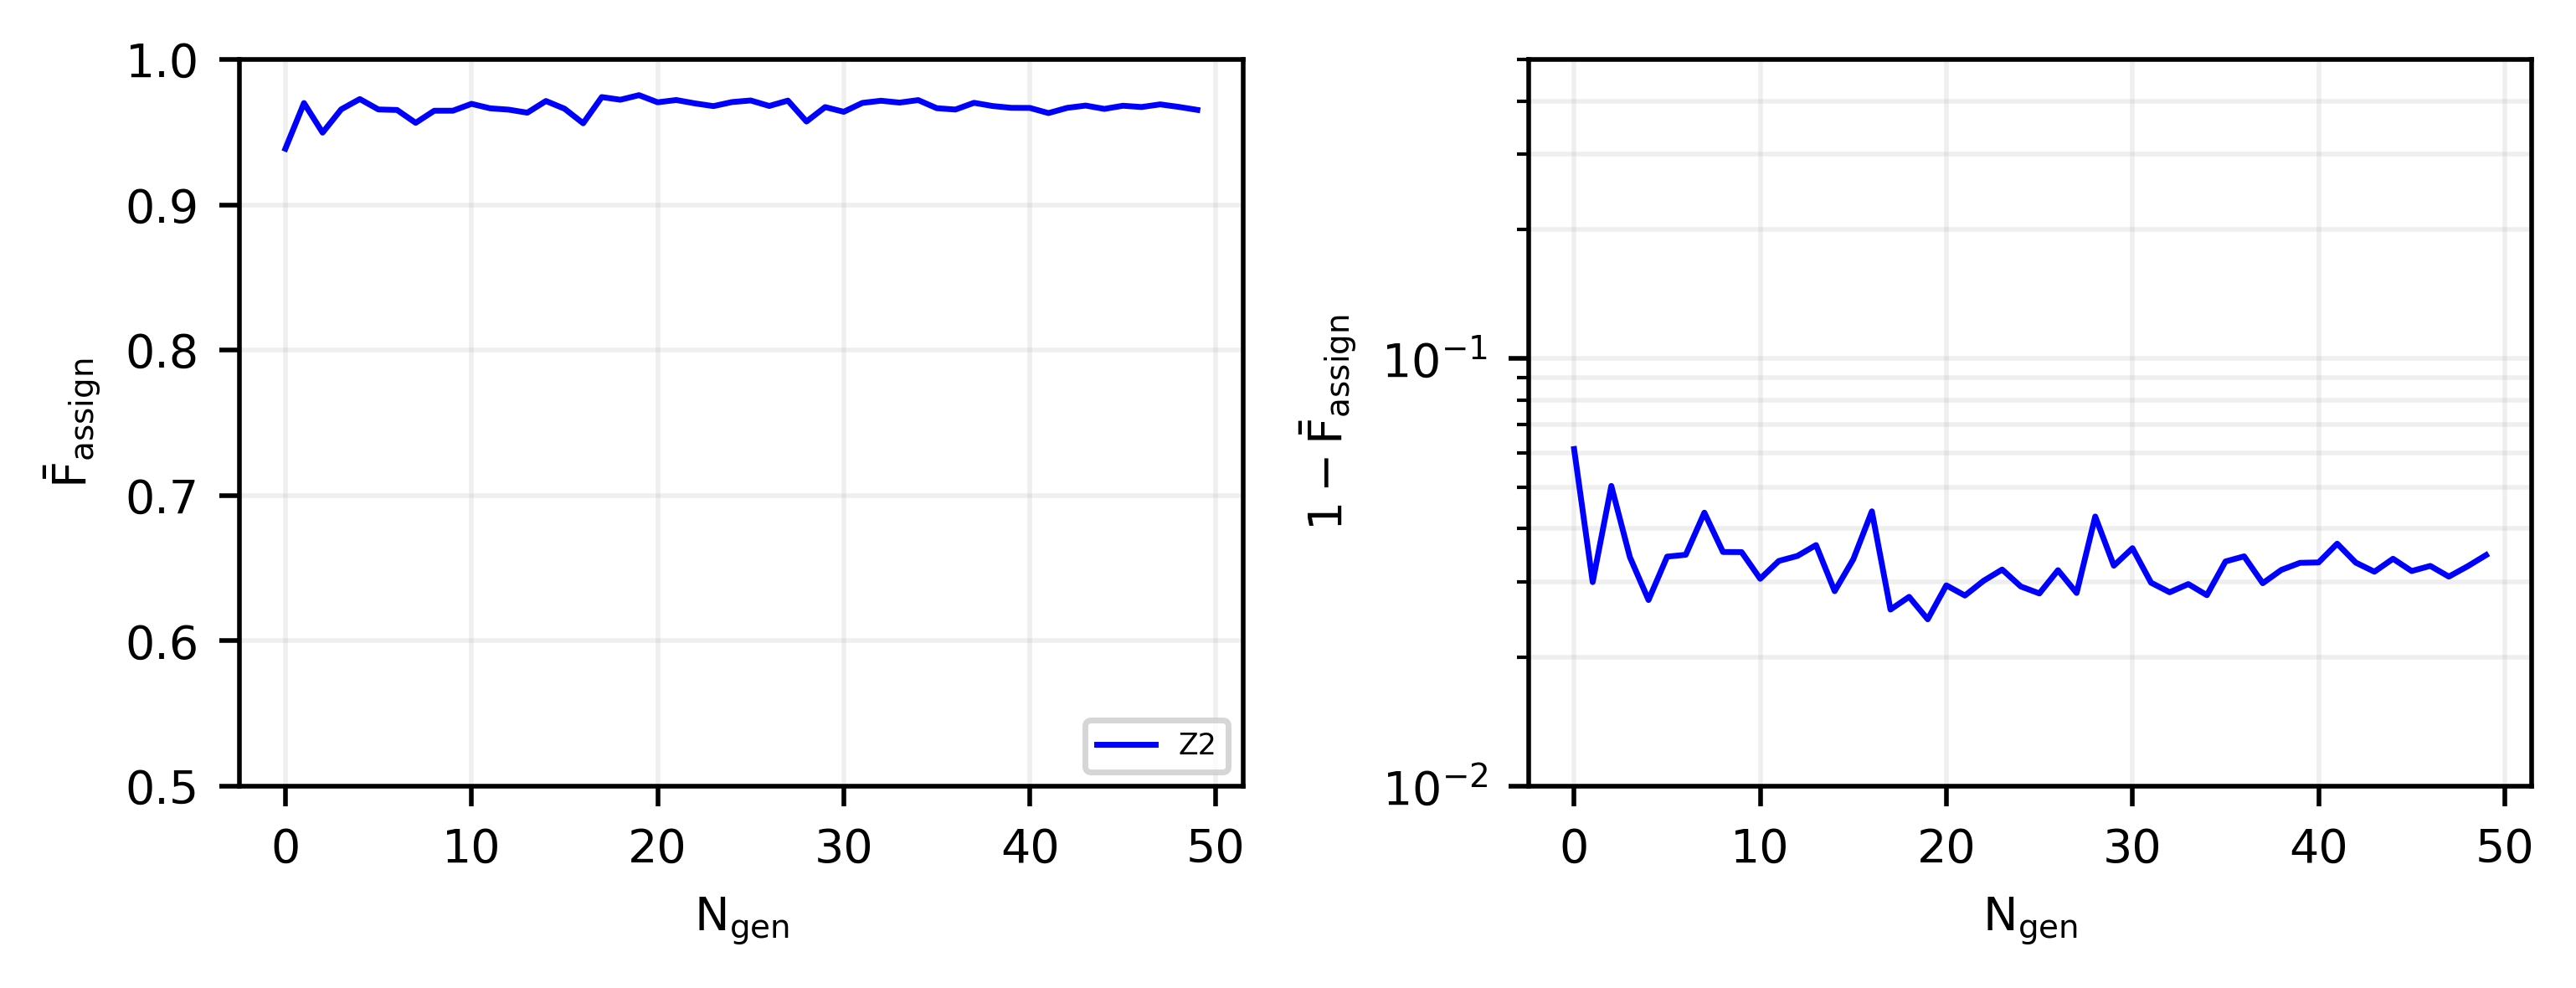

In [7]:
#Singe qubit results
qubit = 'Z'

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)
ax1.plot(range(50), data_1q[qubit]['mean']['assignfid_av'], lw=1, label='Z2', color='blue')
ax2.plot(range(50), 1 - data_1q[qubit]['mean']['assignfid_av'], lw=1,label='Z2', color='blue')

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5, loc='lower right')
ax1.set_ylabel(r'$\bar{\mathrm{F}}_\mathrm{assign}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \bar{\mathrm{F}}_\mathrm{assign}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

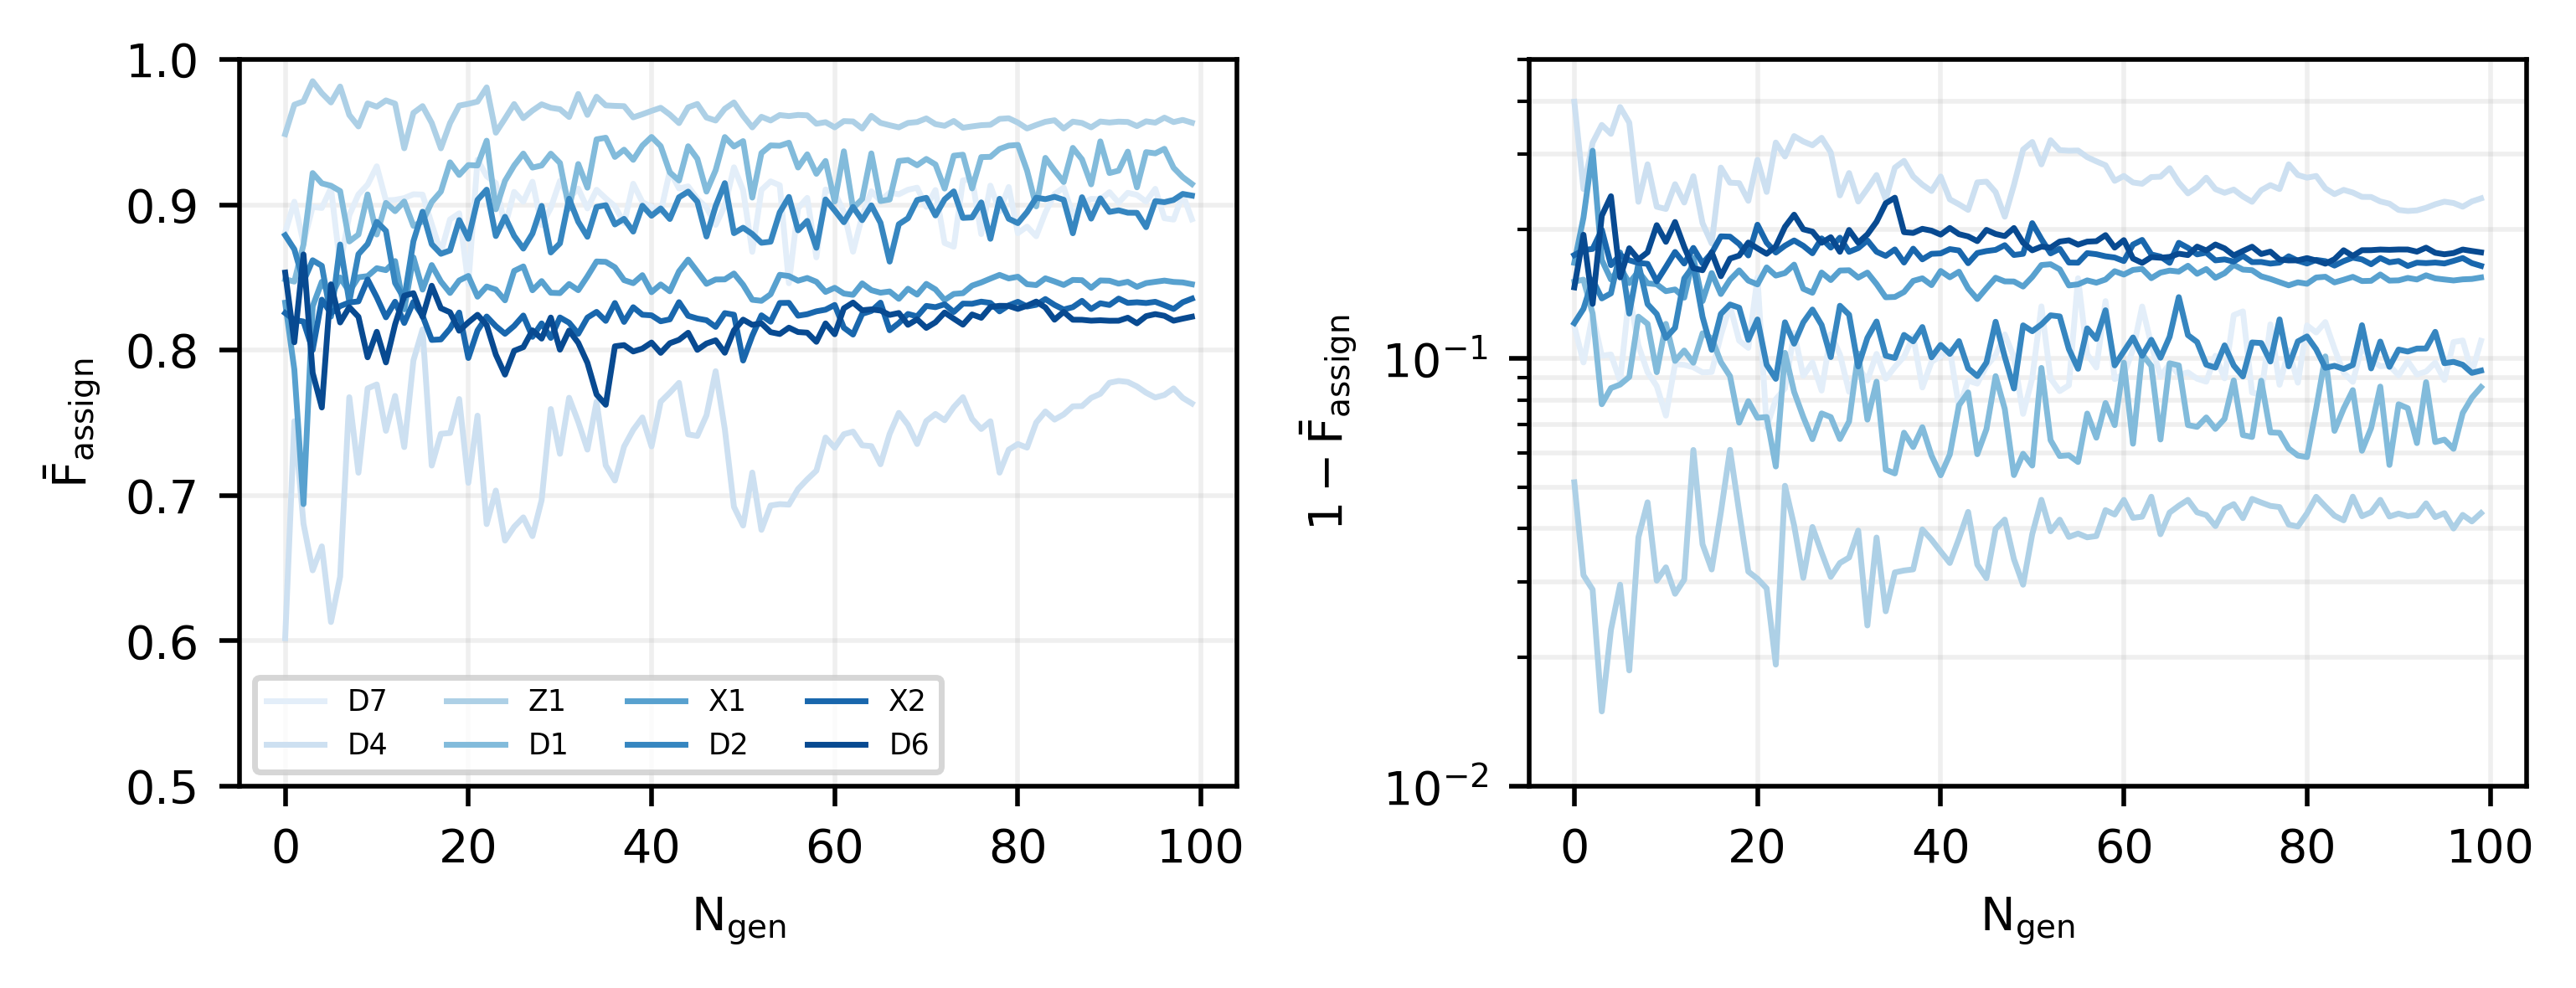

In [8]:
"""
Plot the average assignment fidelity of the multiplexed 7 qubit CMAES with 500 shots
"""
qubits = dataset_8q.elements

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)

# Choose a colormap and generate spaced colors
cmap = mpl.colormaps['Blues']
n = len(qubits)
spacing = np.linspace(0.1, 0.9, n)  # Avoid extremes (too light or too dark)
colors = [cmap(s) for s in spacing]

for idx, qubit in enumerate(qubits):
    color = colors[idx]
    
    ax1.plot(range(100), data_8q[qubit]['mean']['assignfid_av'], lw=1, label=qubit, color=color)
    ax2.plot(range(100), 1 - data_8q[qubit]['mean']['assignfid_av'], lw=1,label=qubit, color=color)

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5)
ax1.set_ylabel(r'$\bar{\mathrm{F}}_\mathrm{assign}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \bar{\mathrm{F}}_\mathrm{assign}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

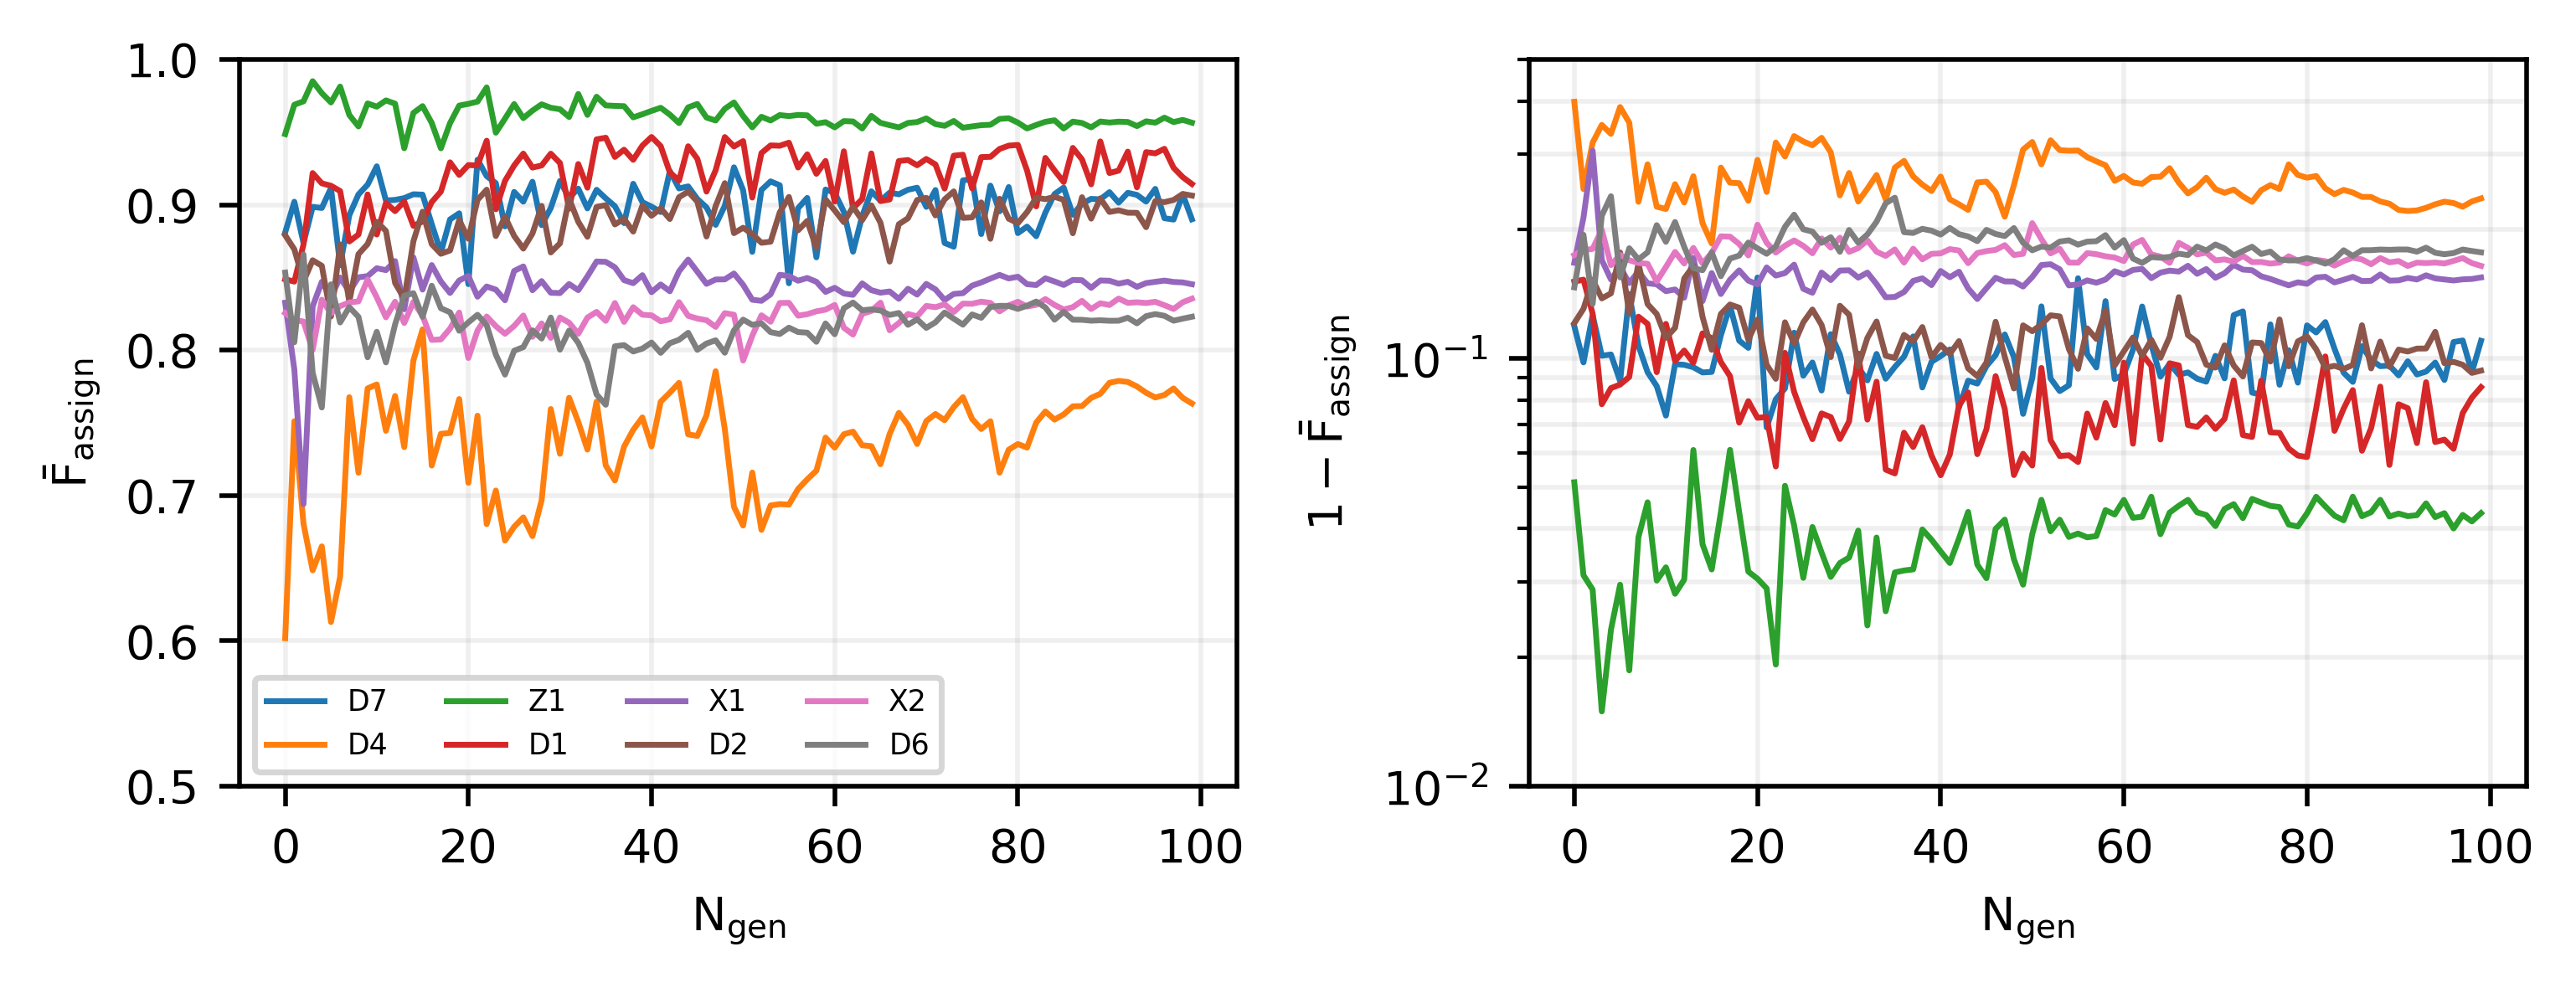

In [9]:
"""
Plot the average assignment fidelity of the multiplexed 7 qubit CMAES with 500 shots
"""
qubits = dataset_8q.elements

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)

for idx, qubit in enumerate(qubits):
    ax1.plot(range(100), data_8q[qubit]['mean']['assignfid_av'], lw=1, label=qubit)
    ax2.plot(range(100), 1 - data_8q[qubit]['mean']['assignfid_av'], lw=1,label=qubit)

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5)
ax1.set_ylabel(r'$\bar{\mathrm{F}}_\mathrm{assign}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \bar{\mathrm{F}}_\mathrm{assign}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

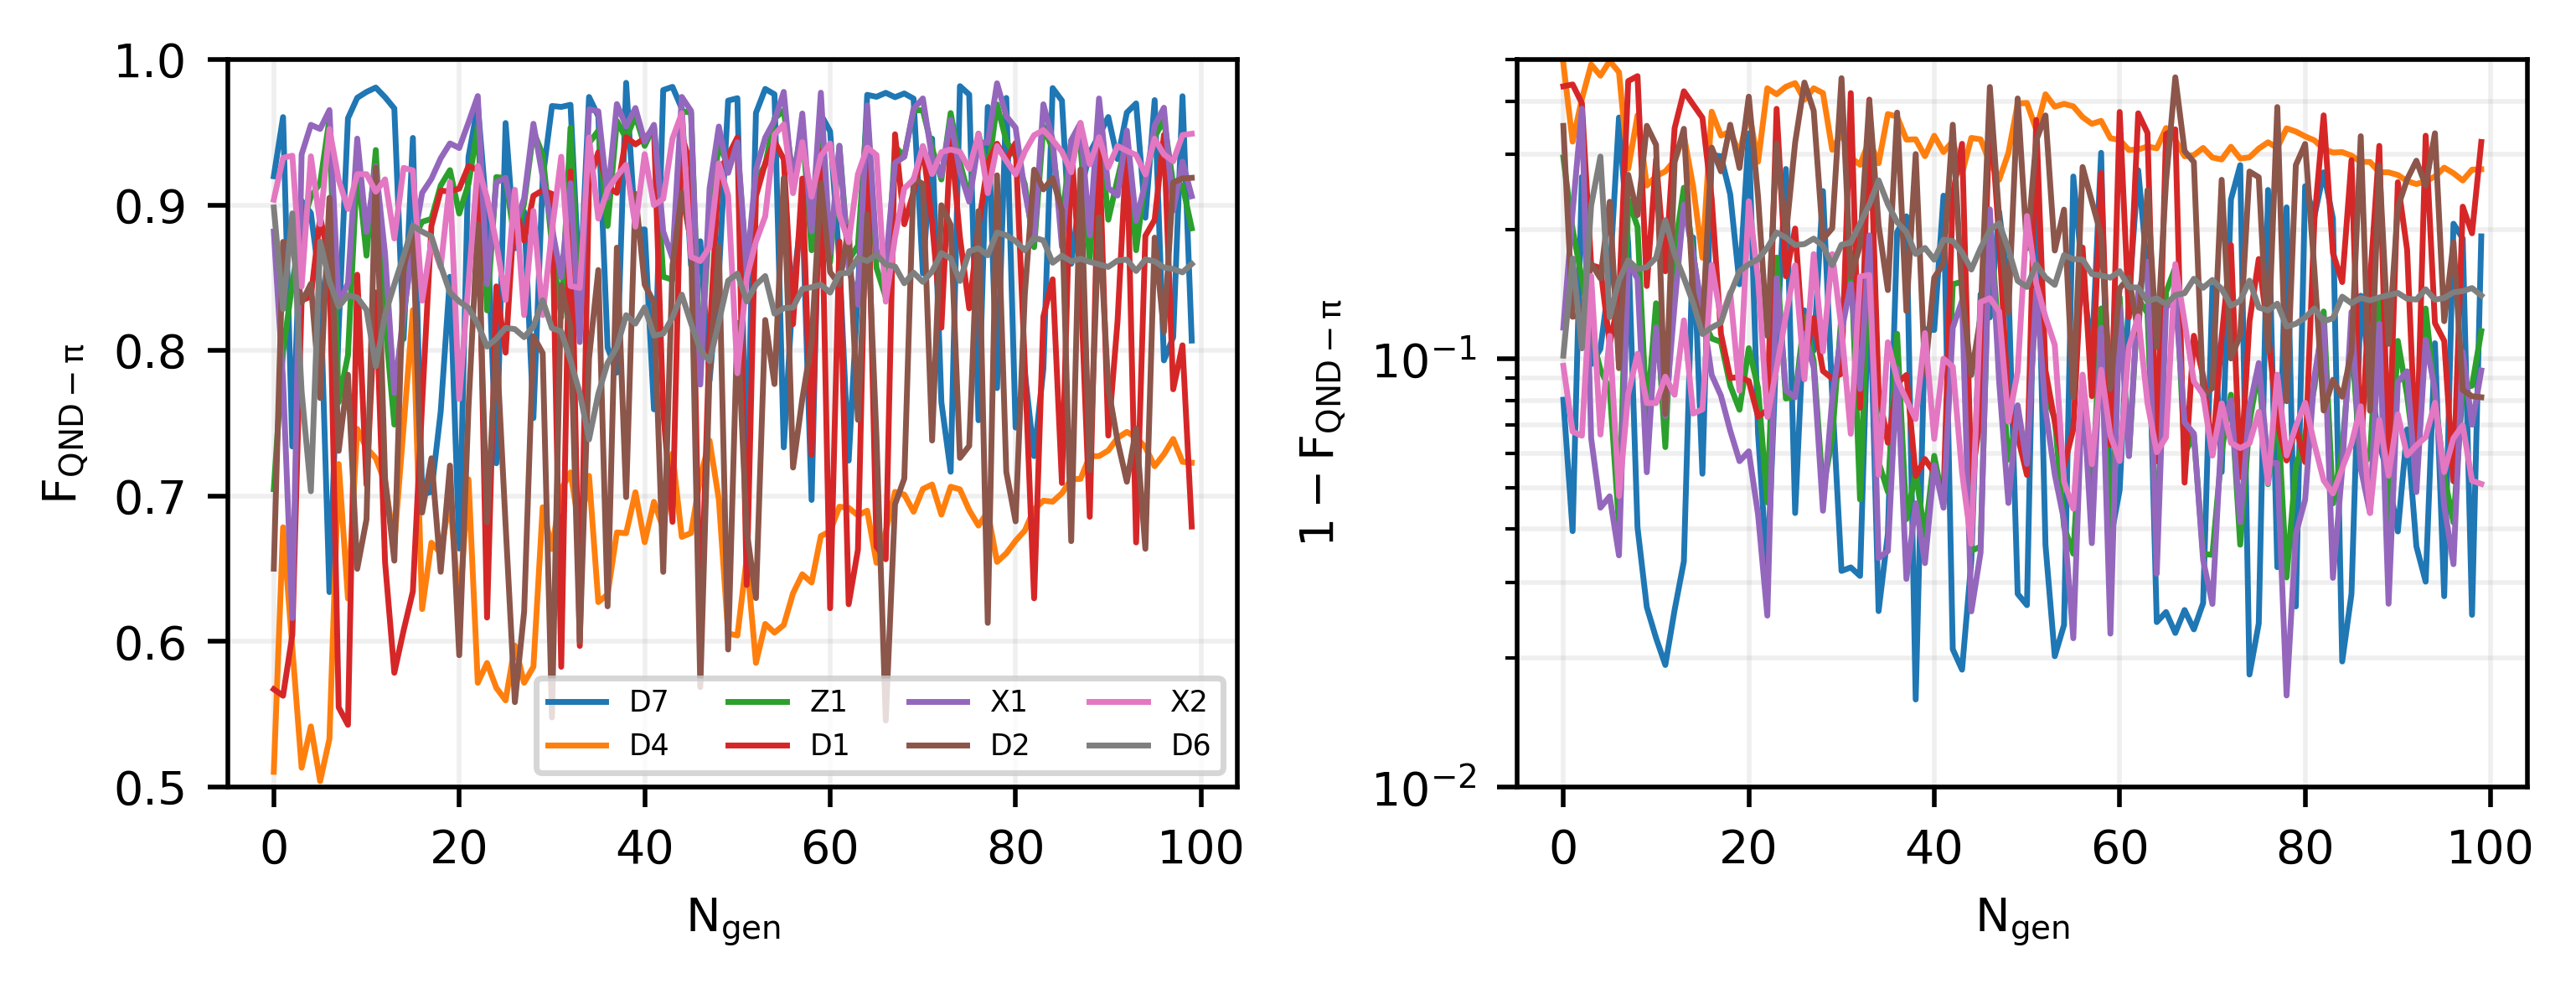

In [10]:
"""
Plot the average assignment fidelity of the multiplexed 7 qubit CMAES with 500 shots
"""
qubits = dataset_8q.elements

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)

for idx, qubit in enumerate(qubits):
    ax1.plot(range(100), data_8q[qubit]['mean']['qndpifid'], lw=1, label=qubit)
    ax2.plot(range(100), 1 - data_8q[qubit]['mean']['qndpifid'], lw=1,label=qubit)

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5)
ax1.set_ylabel(r'$\mathrm{F}_\mathrm{QND-\pi}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \mathrm{F}_\mathrm{QND-\pi}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

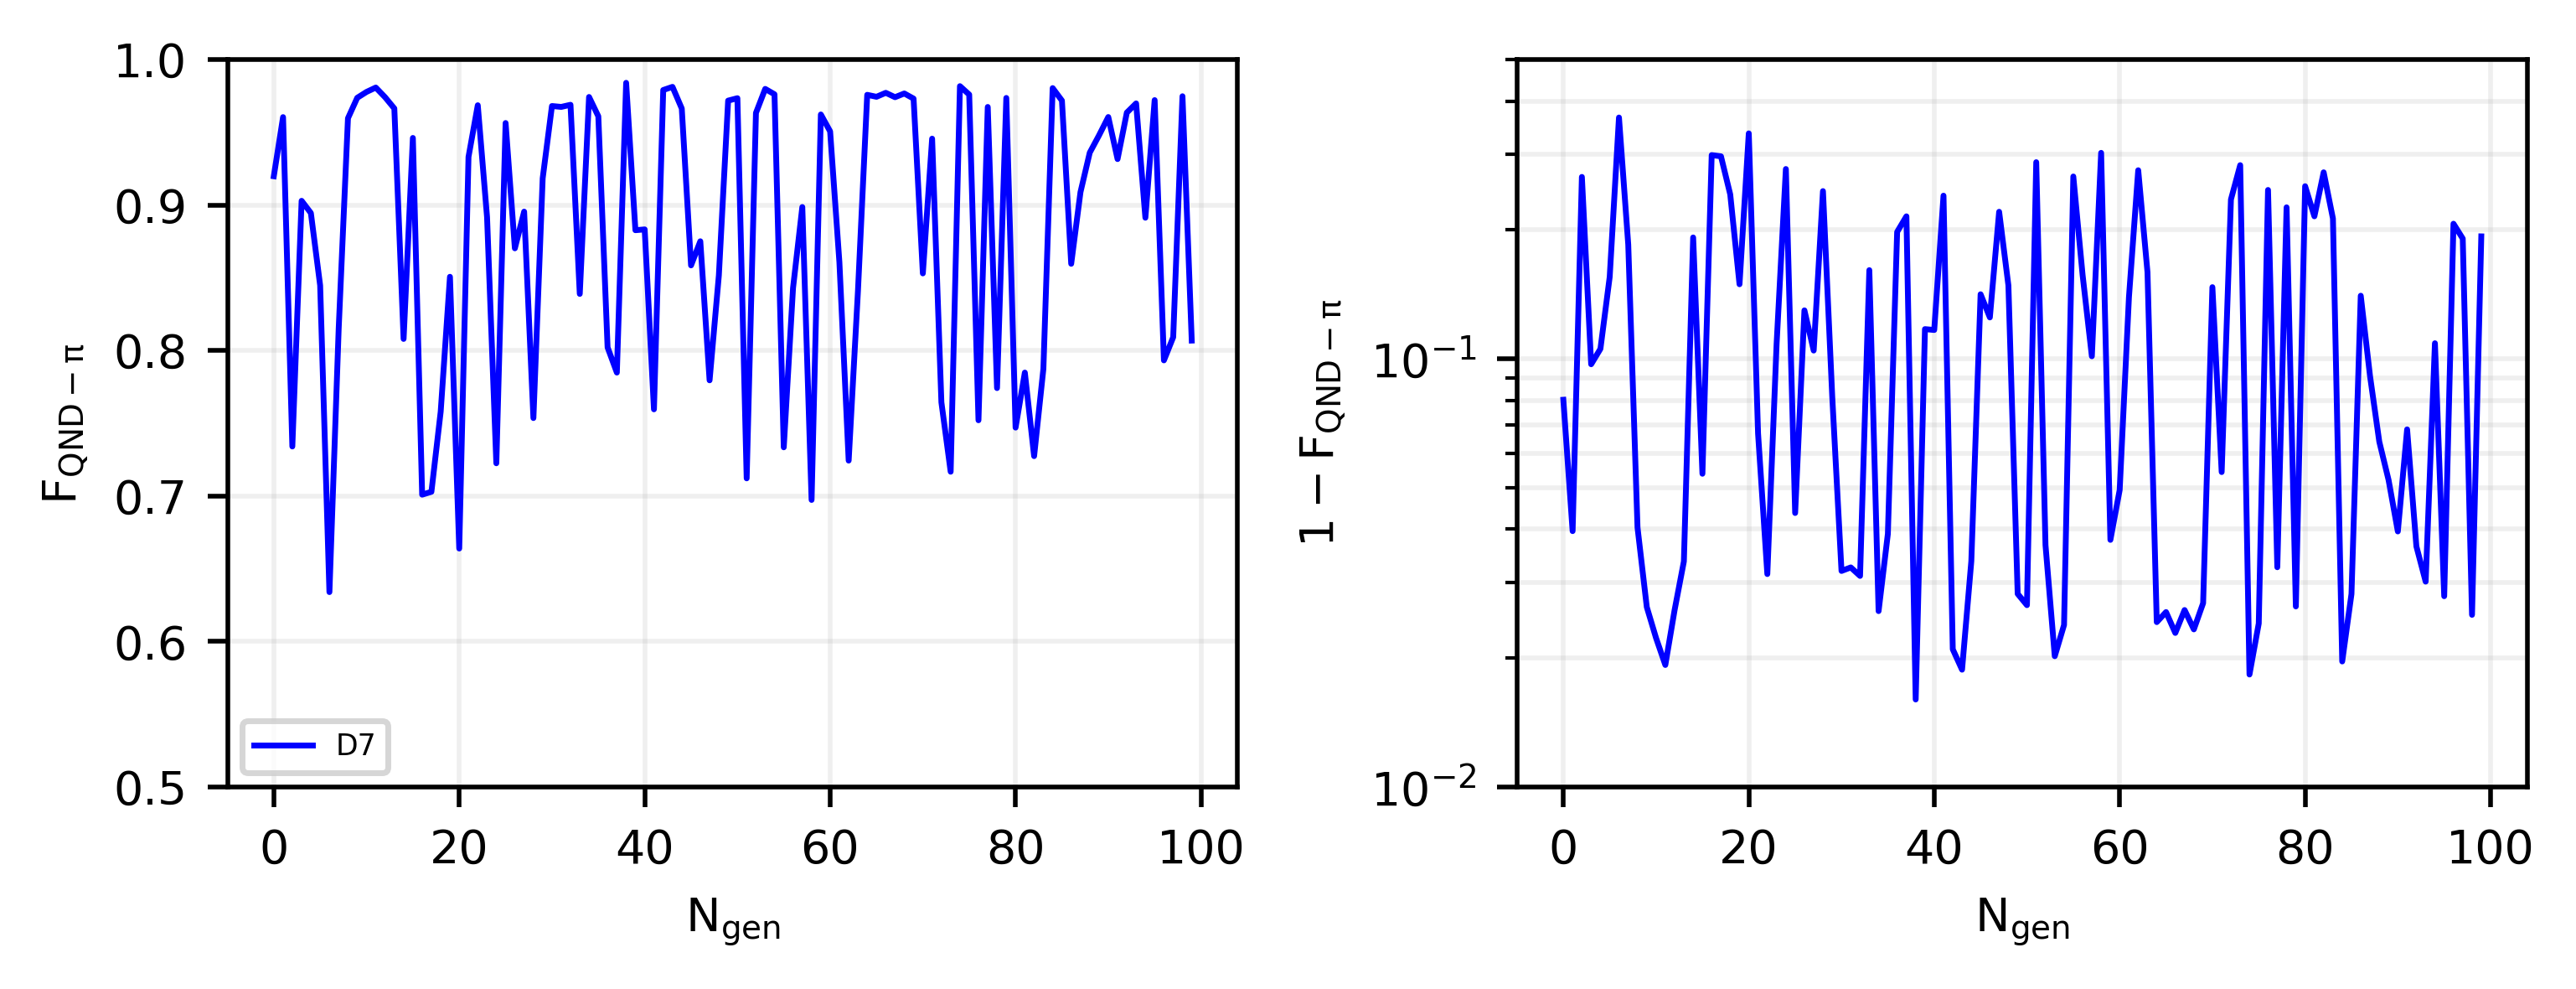

In [11]:
"""
Plot fidelity of single qubit
"""
qubits = dataset_8q.elements

qubit = qubits[0]

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)
ax1.plot(range(100), data_8q[qubit]['mean']['qndpifid'], lw=1, label=qubit, color='blue')
ax2.plot(range(100), 1 - data_8q[qubit]['mean']['qndpifid'], lw=1,label=qubit, color='blue')

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5)
ax1.set_ylabel(r'$\mathrm{F}_\mathrm{QND-\pi}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \mathrm{F}_\mathrm{QND-\pi}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

In [12]:
#QND-pi train 1
tuid = '20250630-123153-603-dbdf9d'
dataset_1q = load_dataset(tuid)
data_1q = process_CMAES_data(dataset_1q, popsize = 16, n_qubits = 1)

# #QND-pi train 10
# tuid = '20250630-131353-315-abbc25'
# dataset_1q = load_dataset(tuid)
# data_1q = process_CMAES_data(dataset_1q, popsize = 16, n_qubits = 1)

In [13]:
dataset_1q

<xarray.Dataset> Size: 68kB
Dimensions:  (dim_0: 850)
Coordinates:
    x0       (dim_0) float64 7kB 6.997e+09 6.994e+09 ... 6.994e+09 6.999e+09
    x1       (dim_0) float64 7kB 0.03917 0.0418 0.05147 ... 0.02421 0.0329
    x2       (dim_0) float64 7kB 3.8e-07 2.32e-07 3.2e-07 ... 3.32e-07 4.4e-07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 7kB -7.687 -6.142 -5.049 ... -6.619 -5.345 -5.096
    y1       (dim_0) float64 7kB 0.981 0.9464 0.9494 ... 0.9762 0.9351 0.9568
    y2       (dim_0) float64 7kB 0.9929 0.9657 0.9459 ... 0.9928 0.9904 0.9919
    y3       (dim_0) float64 7kB 0.9948 0.9898 0.9689 ... 0.9975 0.9955 0.9963
    y4       (dim_0) float64 7kB 0.9552 0.8838 0.9334 ... 0.9383 0.8195 0.8824
    y5       (dim_0) float64 7kB 0.9848 0.9575 0.893 ... 0.9807 0.9782 0.9815
    y6       (dim_0) float64 7kB 0.9759 0.9599 0.8732 ... 0.9439 0.9264 0.8582
Attributes:
    tuid:                             20250630-123153-603-dbdf9d
    name:                             CMAES_QNDPi_Readout_Adaptive_Reps ['D1']
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  True
    elements:                         D1
    edges:                            []

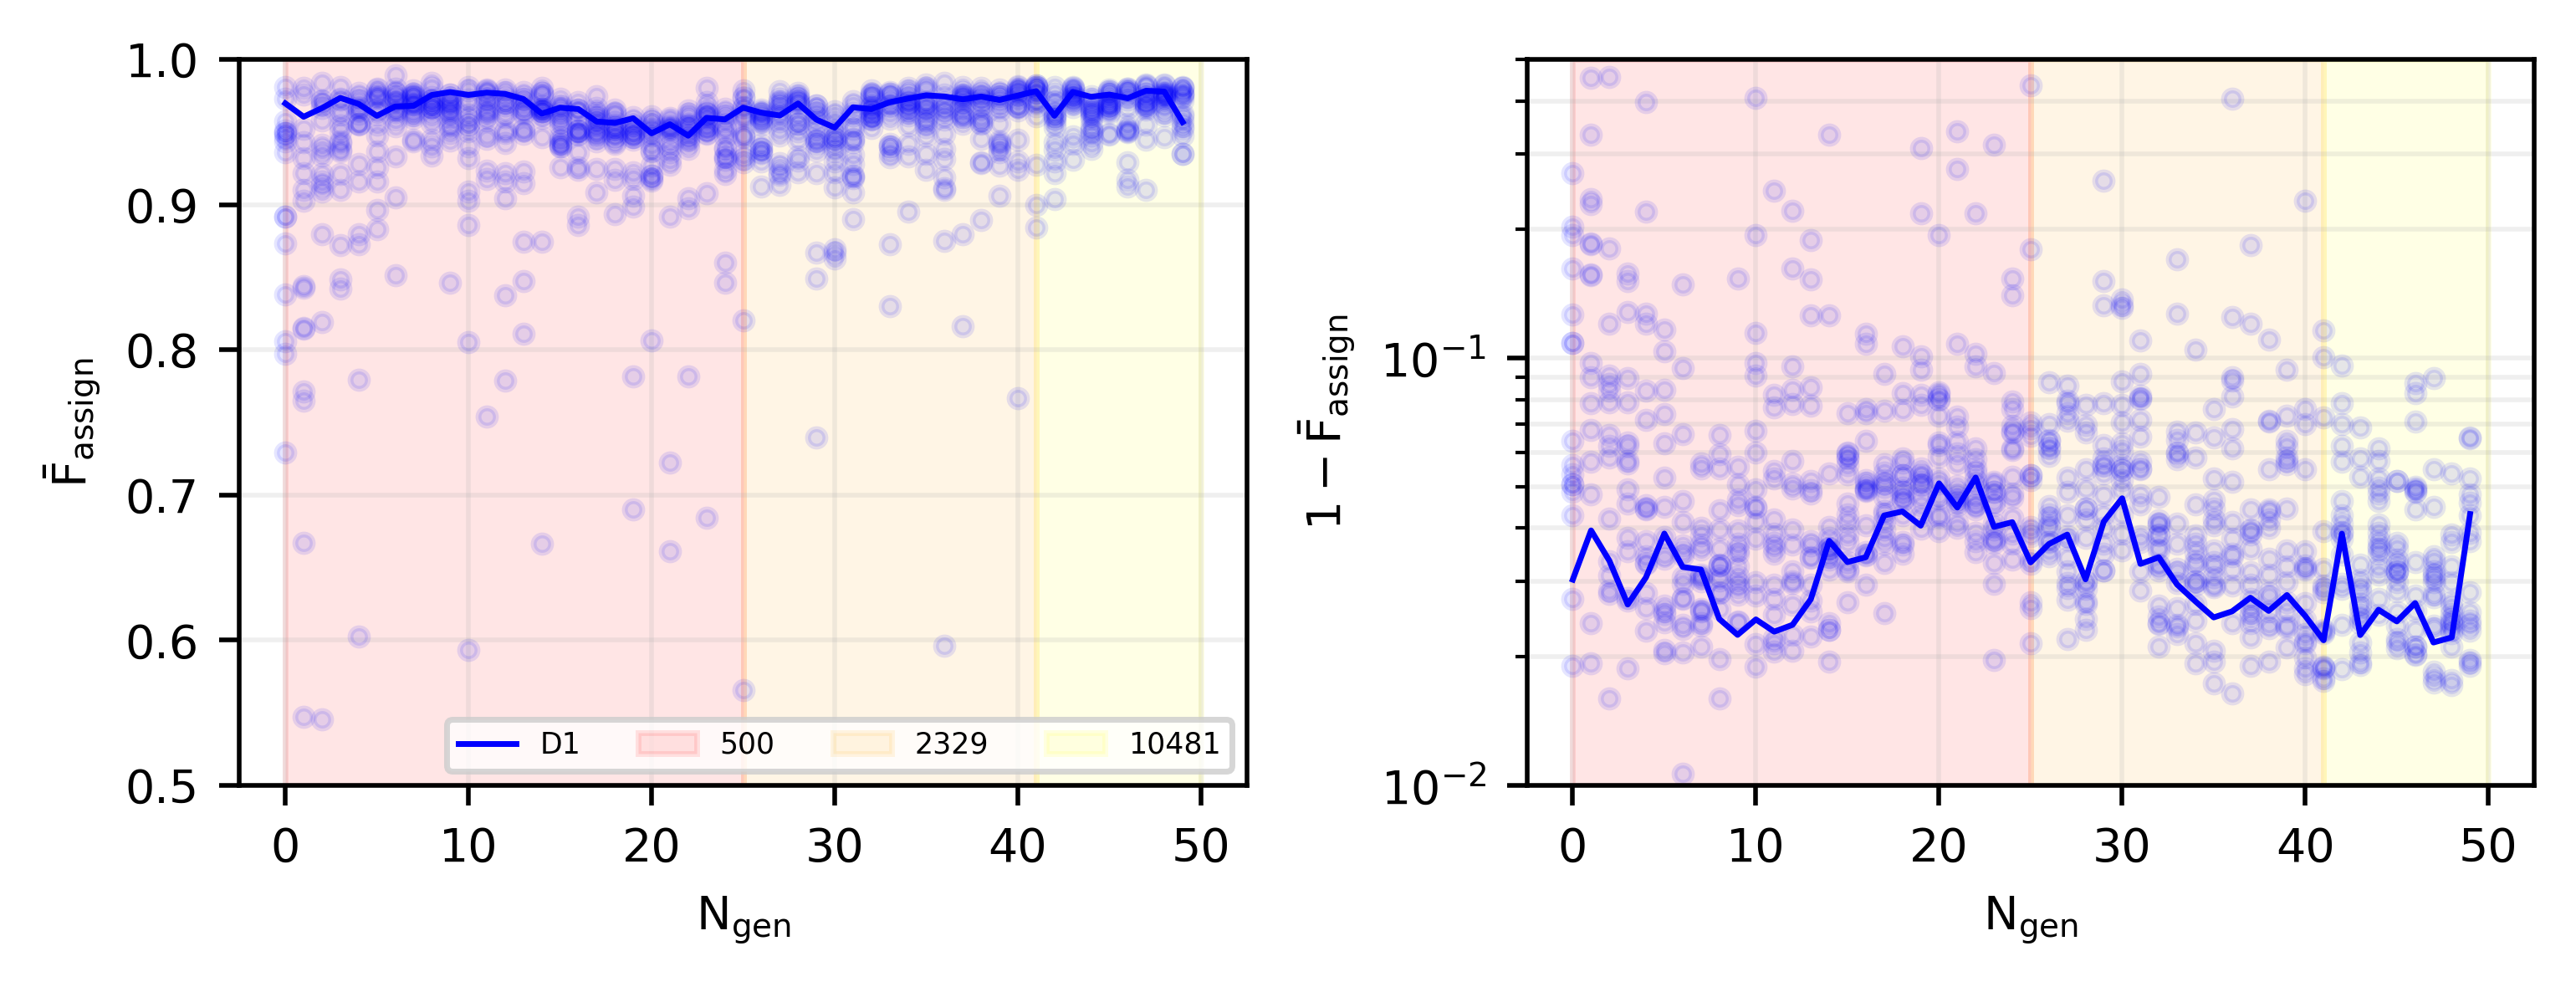

In [14]:
popsize = 16
Ngen = 50

red_end = 25
orange_end = 41
yellow_end = 50

#Singe qubit results
qubit = 'D'

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)
ax1.plot(range(50), data_1q[qubit]['mean']['assignfid_av'], lw=1, label='D1', color='blue')
ax2.plot(range(50), 1 - data_1q[qubit]['mean']['assignfid_av'], lw=1,label='D1', color='blue')

for i in range(popsize):
    ax1.plot(range(Ngen),data_1q[qubit]['pop']['assignfid_av'][i],".",c="blue",alpha=.1)
    ax2.plot(range(Ngen),1-data_1q[qubit]['pop']['assignfid_av'][i],".",c="blue",alpha=.1)

#plot where we change repetitions:
ax1.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax1.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax1.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax2.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax2.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax2.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5, loc='lower right')
ax1.set_ylabel(r'$\bar{\mathrm{F}}_\mathrm{assign}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \bar{\mathrm{F}}_\mathrm{assign}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

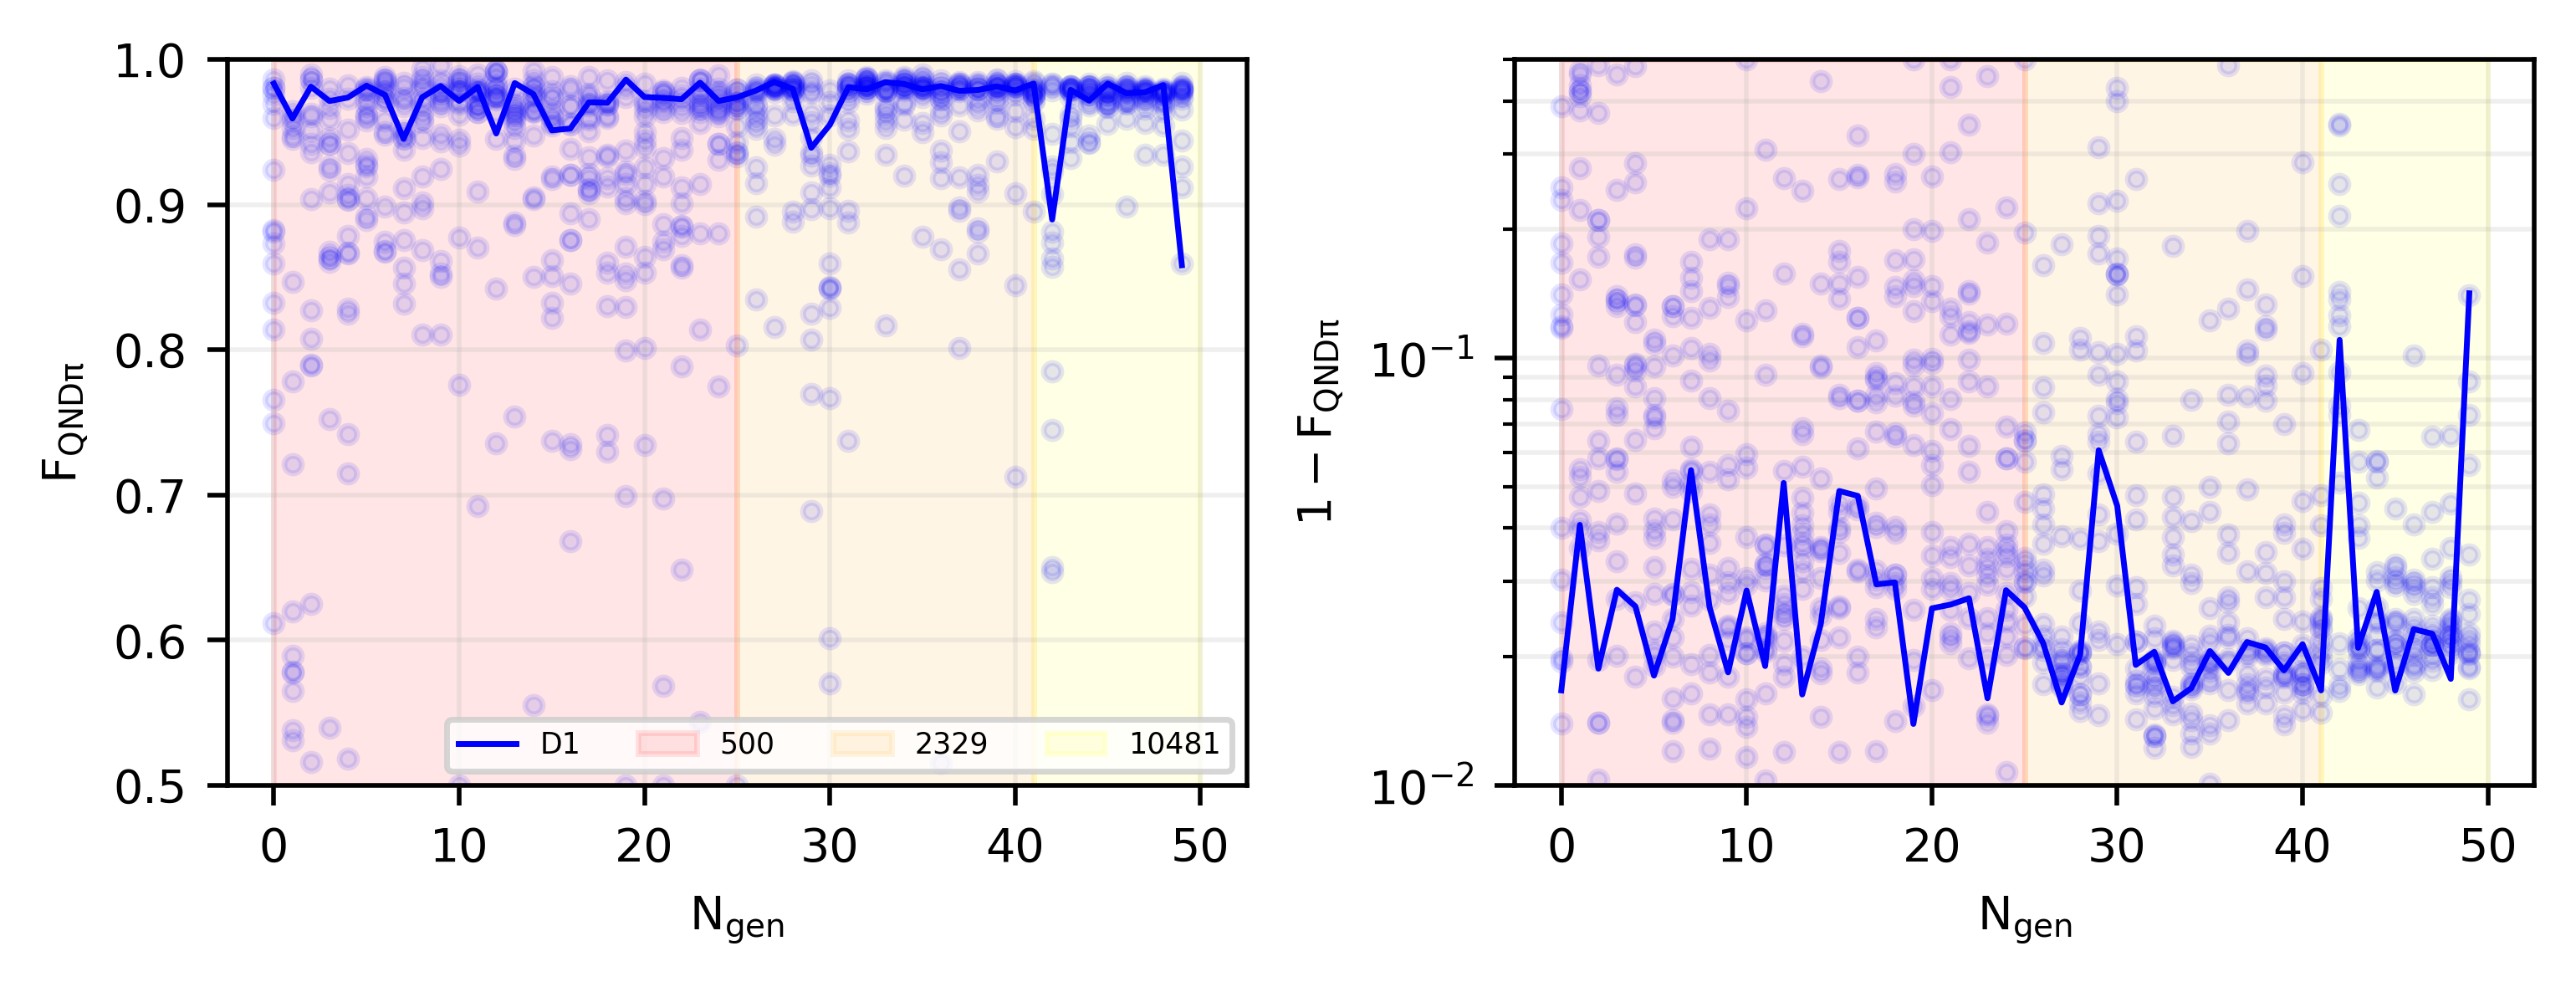

In [15]:
#Singe qubit results
qubit = 'D'

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)
ax1.plot(range(50), data_1q[qubit]['mean']['qndpifid'], lw=1, label='D1', color='blue')
ax2.plot(range(50), 1 - data_1q[qubit]['mean']['qndpifid'], lw=1,label='D1', color='blue')

for i in range(popsize):
    ax1.plot(range(Ngen),data_1q[qubit]['pop']['qndpifid'][i],".",c="blue",alpha=.1)
    ax2.plot(range(Ngen),1-data_1q[qubit]['pop']['qndpifid'][i],".",c="blue",alpha=.1)

#plot where we change repetitions:
ax1.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax1.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax1.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax2.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax2.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax2.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5, loc='lower right')
ax1.set_ylabel(r'$\mathrm{F}_\mathrm{QND \pi}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \mathrm{F}_\mathrm{QND \pi}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

plt.tight_layout()
plt.show()

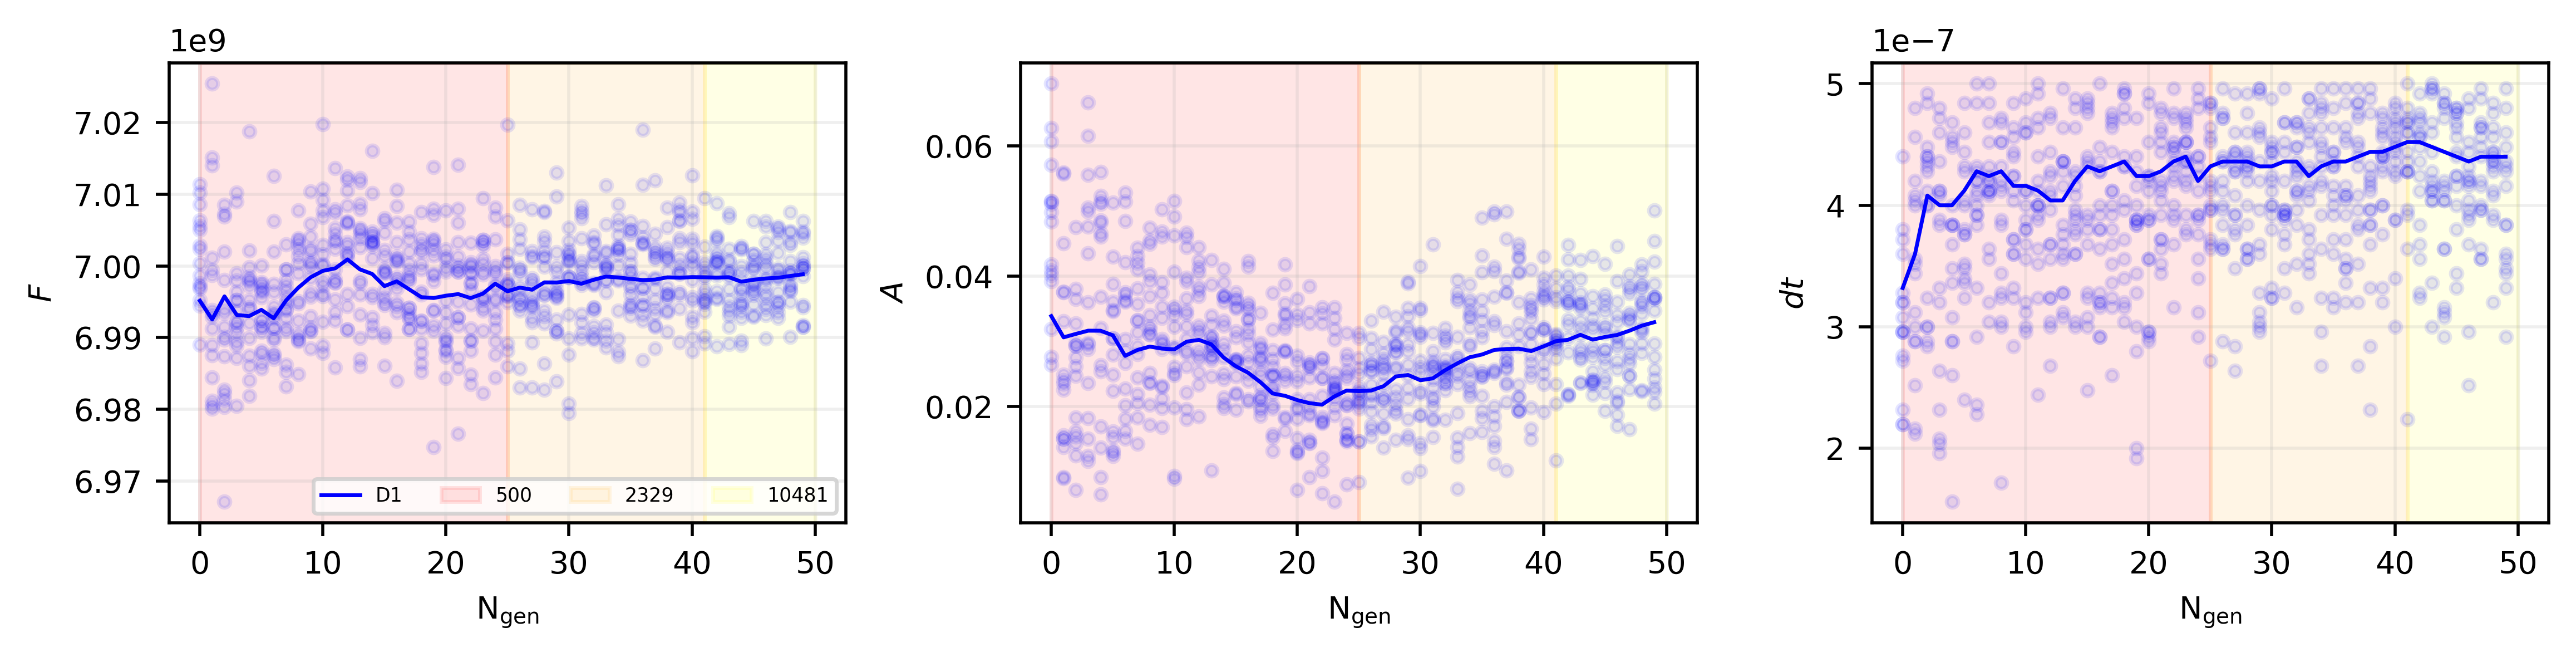

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=1)
ax1 = axes[0]
ax2 = axes[1]
ax3 = axes[2]

fig.set_size_inches(9.3, 2.4)
ax1.plot(range(50), data_1q[qubit]['mean']['freq'], lw=1, label='D1', color='blue')
ax2.plot(range(50), data_1q[qubit]['mean']['ampl'], lw=1,label='D1', color='blue')
ax3.plot(range(50), data_1q[qubit]['mean']['dur'], lw=1,label='D1', color='blue')

for i in range(popsize):
    ax1.plot(range(Ngen),data_1q[qubit]['pop']['freq'][i],".",c="blue",alpha=.1)
    ax2.plot(range(Ngen),data_1q[qubit]['pop']['ampl'][i],".",c="blue",alpha=.1)
    ax3.plot(range(Ngen),data_1q[qubit]['pop']['dur'][i],".",c="blue",alpha=.1)

#plot where we change repetitions:
ax1.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax1.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax1.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax2.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax2.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax2.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax3.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax3.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax3.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.legend(ncols=4, fontsize=5, loc='lower right')
ax1.set_ylabel(r'$F$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
# ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$A$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
# ax2.set_ylim(0.5, 1)

ax3.grid(which='both', alpha=.2)
ax3.set_ylabel(r'$dt$')
ax3.set_xlabel(r'N$_\mathrm{gen}$')
# ax3.set_ylim(0.5, 1)

plt.tight_layout()
plt.show()

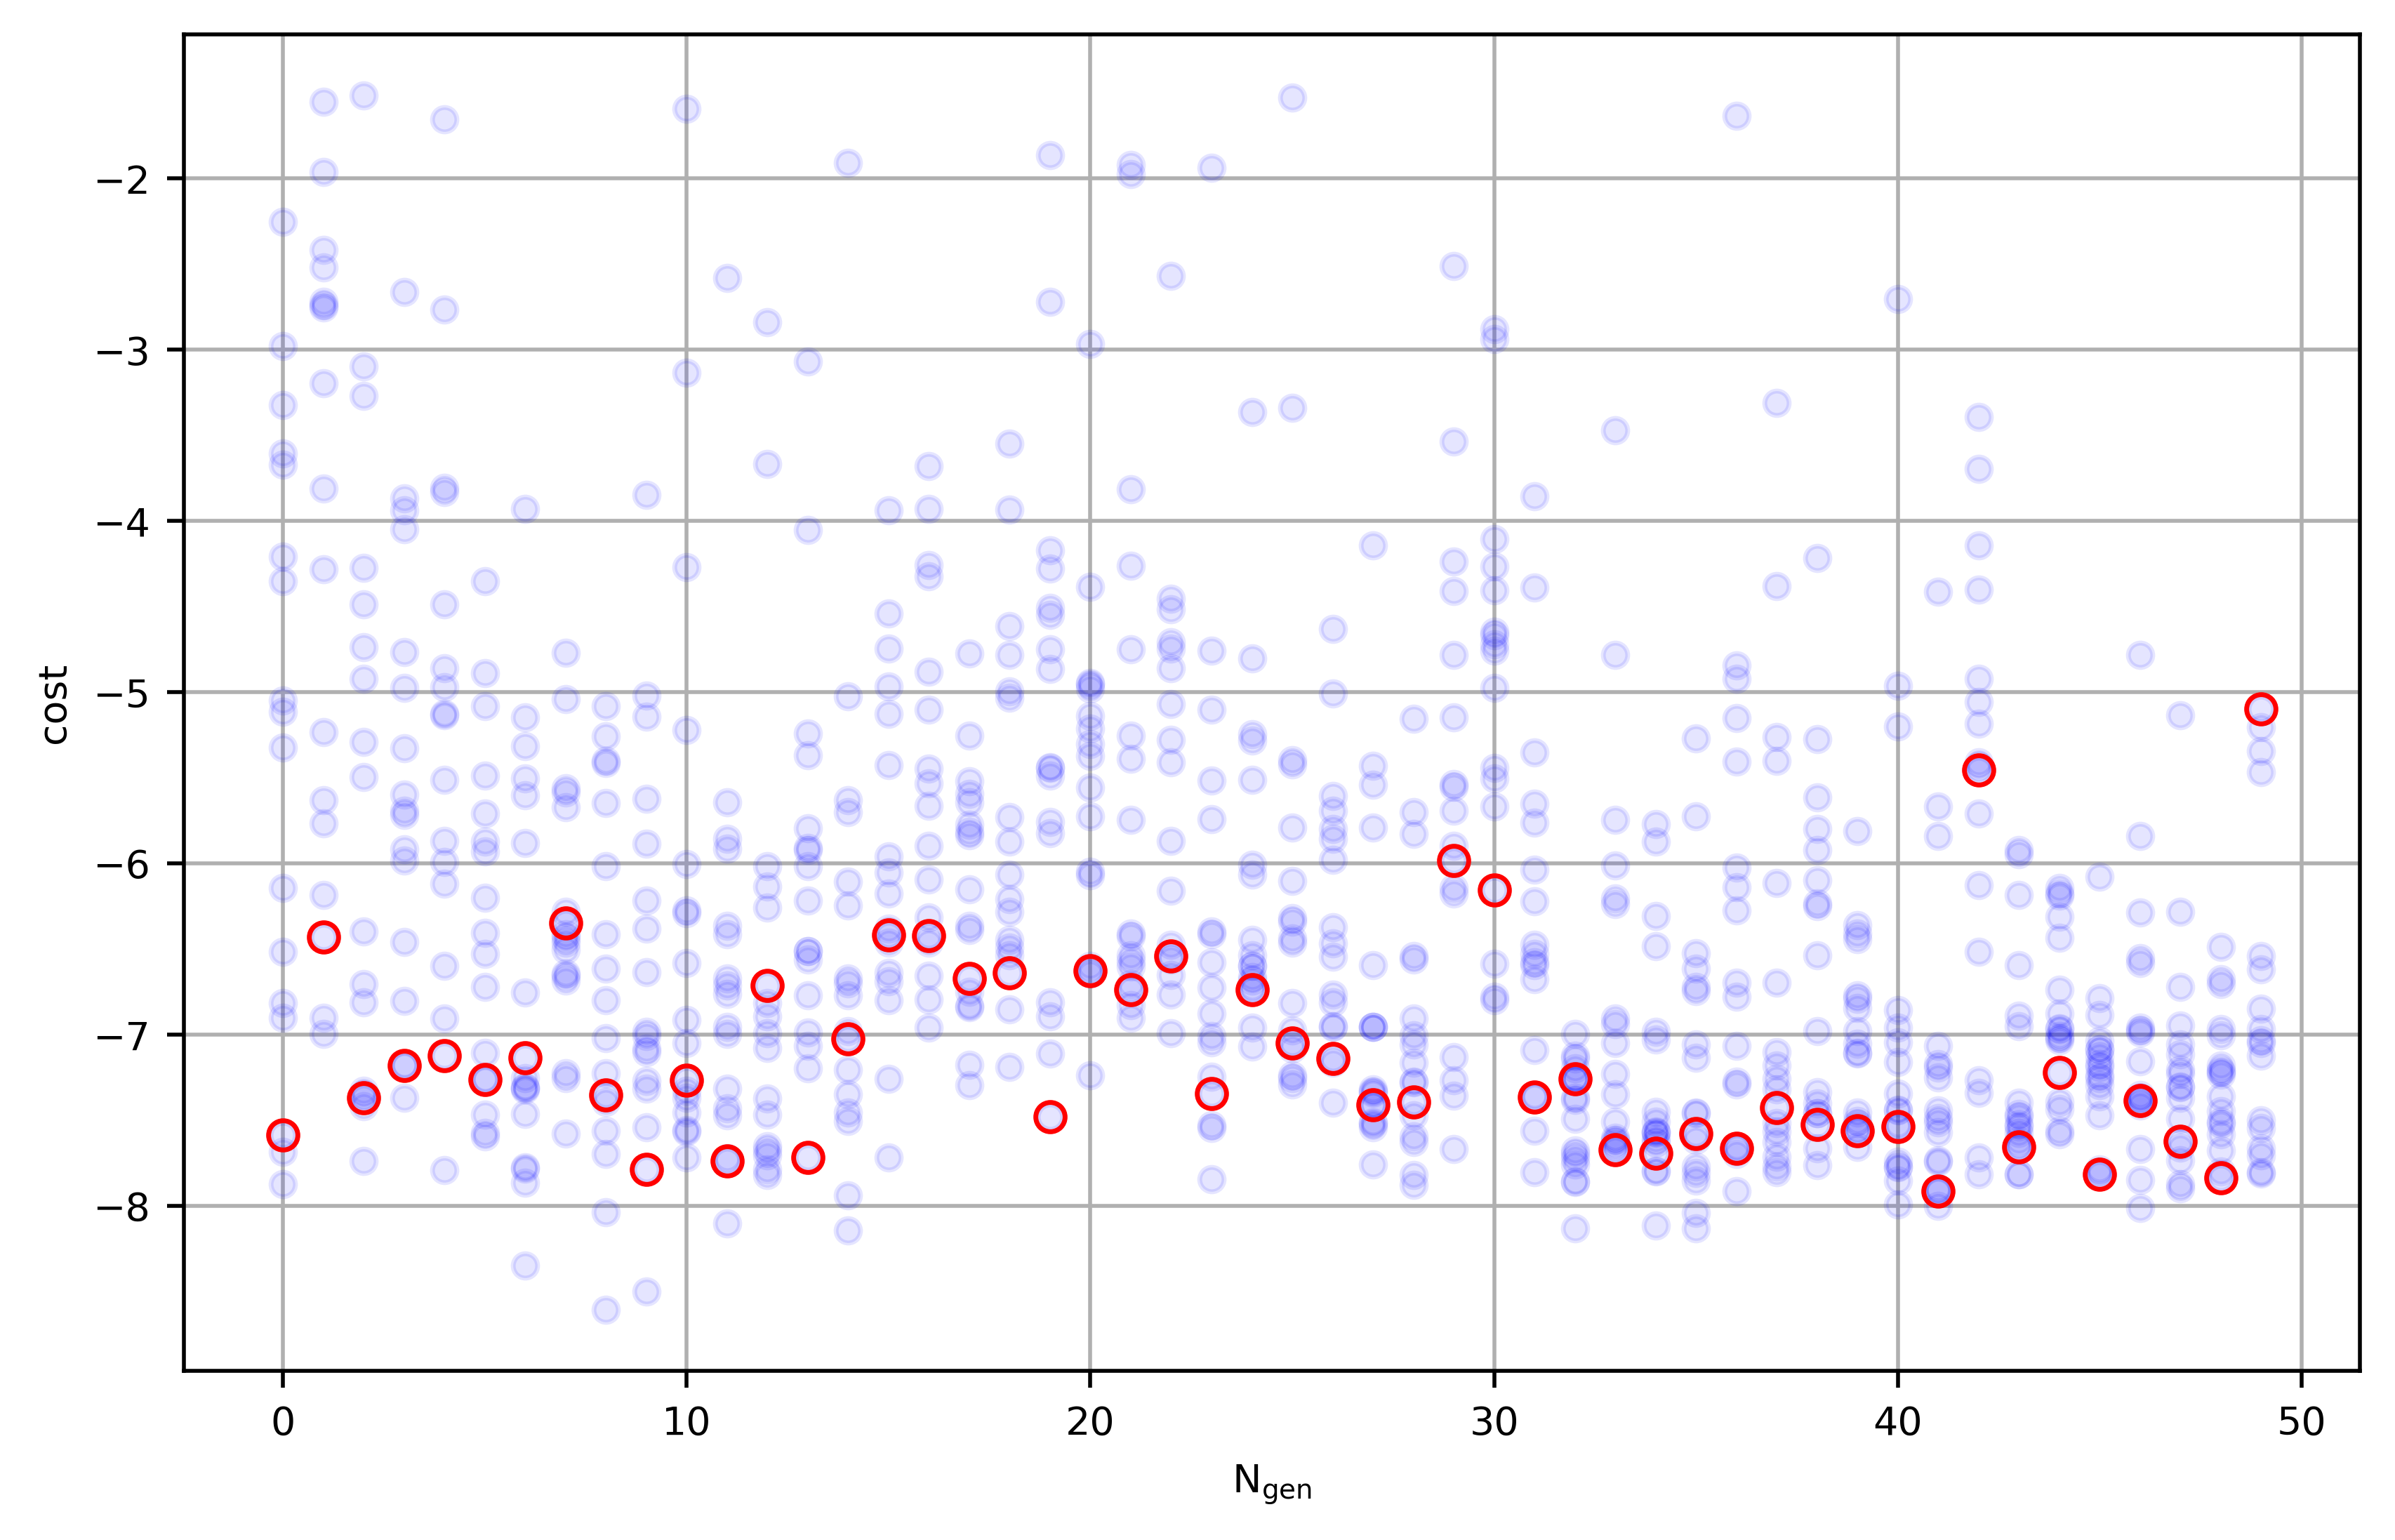

In [20]:
freq_all = dataset_1q['x0'].values
ampl_all = dataset_1q['x1'].values
dur_all = dataset_1q['x2'].values
objective_all = dataset_1q['y0'].values

freq = freq_all.reshape(Ngen, popsize+1)
ampl = ampl_all.reshape(Ngen, popsize+1)
dur = dur_all.reshape(Ngen, popsize+1)
objective = objective_all.reshape(Ngen, popsize+1)
         
for gen in range(Ngen):
    if gen <= 1/2*Ngen:  
        plt.plot(np.repeat(gen,popsize+1),objective[gen,:], ".", c='blue', ms=10, alpha=.1)

    elif gen <= 5/6*Ngen:
        plt.plot(np.repeat(gen,popsize+1),objective[gen,:], ".", c='blue', ms=10, alpha=.1)

    else:
        plt.plot(np.repeat(gen,popsize+1),objective[gen,:], ".", c='blue', ms=10, alpha=.1)

plt.plot(range(Ngen), objective_all[popsize::popsize+1], marker="o", ls = "none", color="red", markerfacecolor='none', ms=6)
plt.xlabel(r'N$_\mathrm{gen}$')
plt.ylabel('cost')
plt.grid()
plt.show()

In [24]:
orange_obj = objective[26:42,:].flatten()
red_obj = objective[42:,:].flatten()

orange_freq = freq[26:42,:].flatten()
red_freq = freq[42:,:].flatten()

orange_ampl = ampl[26:42,:].flatten()
red_ampl = ampl[42:,:].flatten()

orange_dur = dur[26:42,:].flatten()
red_dur = dur[42:,:].flatten()

orange_min = np.argmin(orange_obj)
red_min = np.argmin(red_obj)

freq_optim_orange = orange_freq[orange_min]
ampl_optim_orange = orange_ampl[orange_min]
dur_optim_orange = orange_dur[orange_min]

freq_optim_red = red_freq[red_min]
ampl_optim_red = red_ampl[red_min]
dur_optim_red = red_dur[red_min]

print(f"Orange: \n freq: {freq_optim_orange}, \n ampl: {ampl_optim_orange}, \n dur: {dur_optim_orange}") 
print()
print(f"Red: \n freq: {freq_optim_red}, \n ampl: {ampl_optim_red}, \n dur: {dur_optim_red}") 
print()

print("Objective orange: ", orange_obj[orange_min])
print("Objective red: ", red_obj[red_min])

Orange: 
 freq: 7001616058.59841, 
 ampl: 0.029815551192273883, 
 dur: 4.2400000000000004e-07

red: 
 freq: 7000325114.587381, 
 ampl: 0.03394754104908606, 
 dur: 4.52e-07

Objective orange:  -8.132438403952008
Objective red:  -8.011995658982675


In [32]:
#QND-pi train 1
Ngen = 50
popsize = 32
n_qubits = 3

tuid = '20250630-144327-867-9e765d'
dataset = load_dataset(tuid)
data = process_CMAES_data(dataset, popsize = popsize, n_qubits = n_qubits)


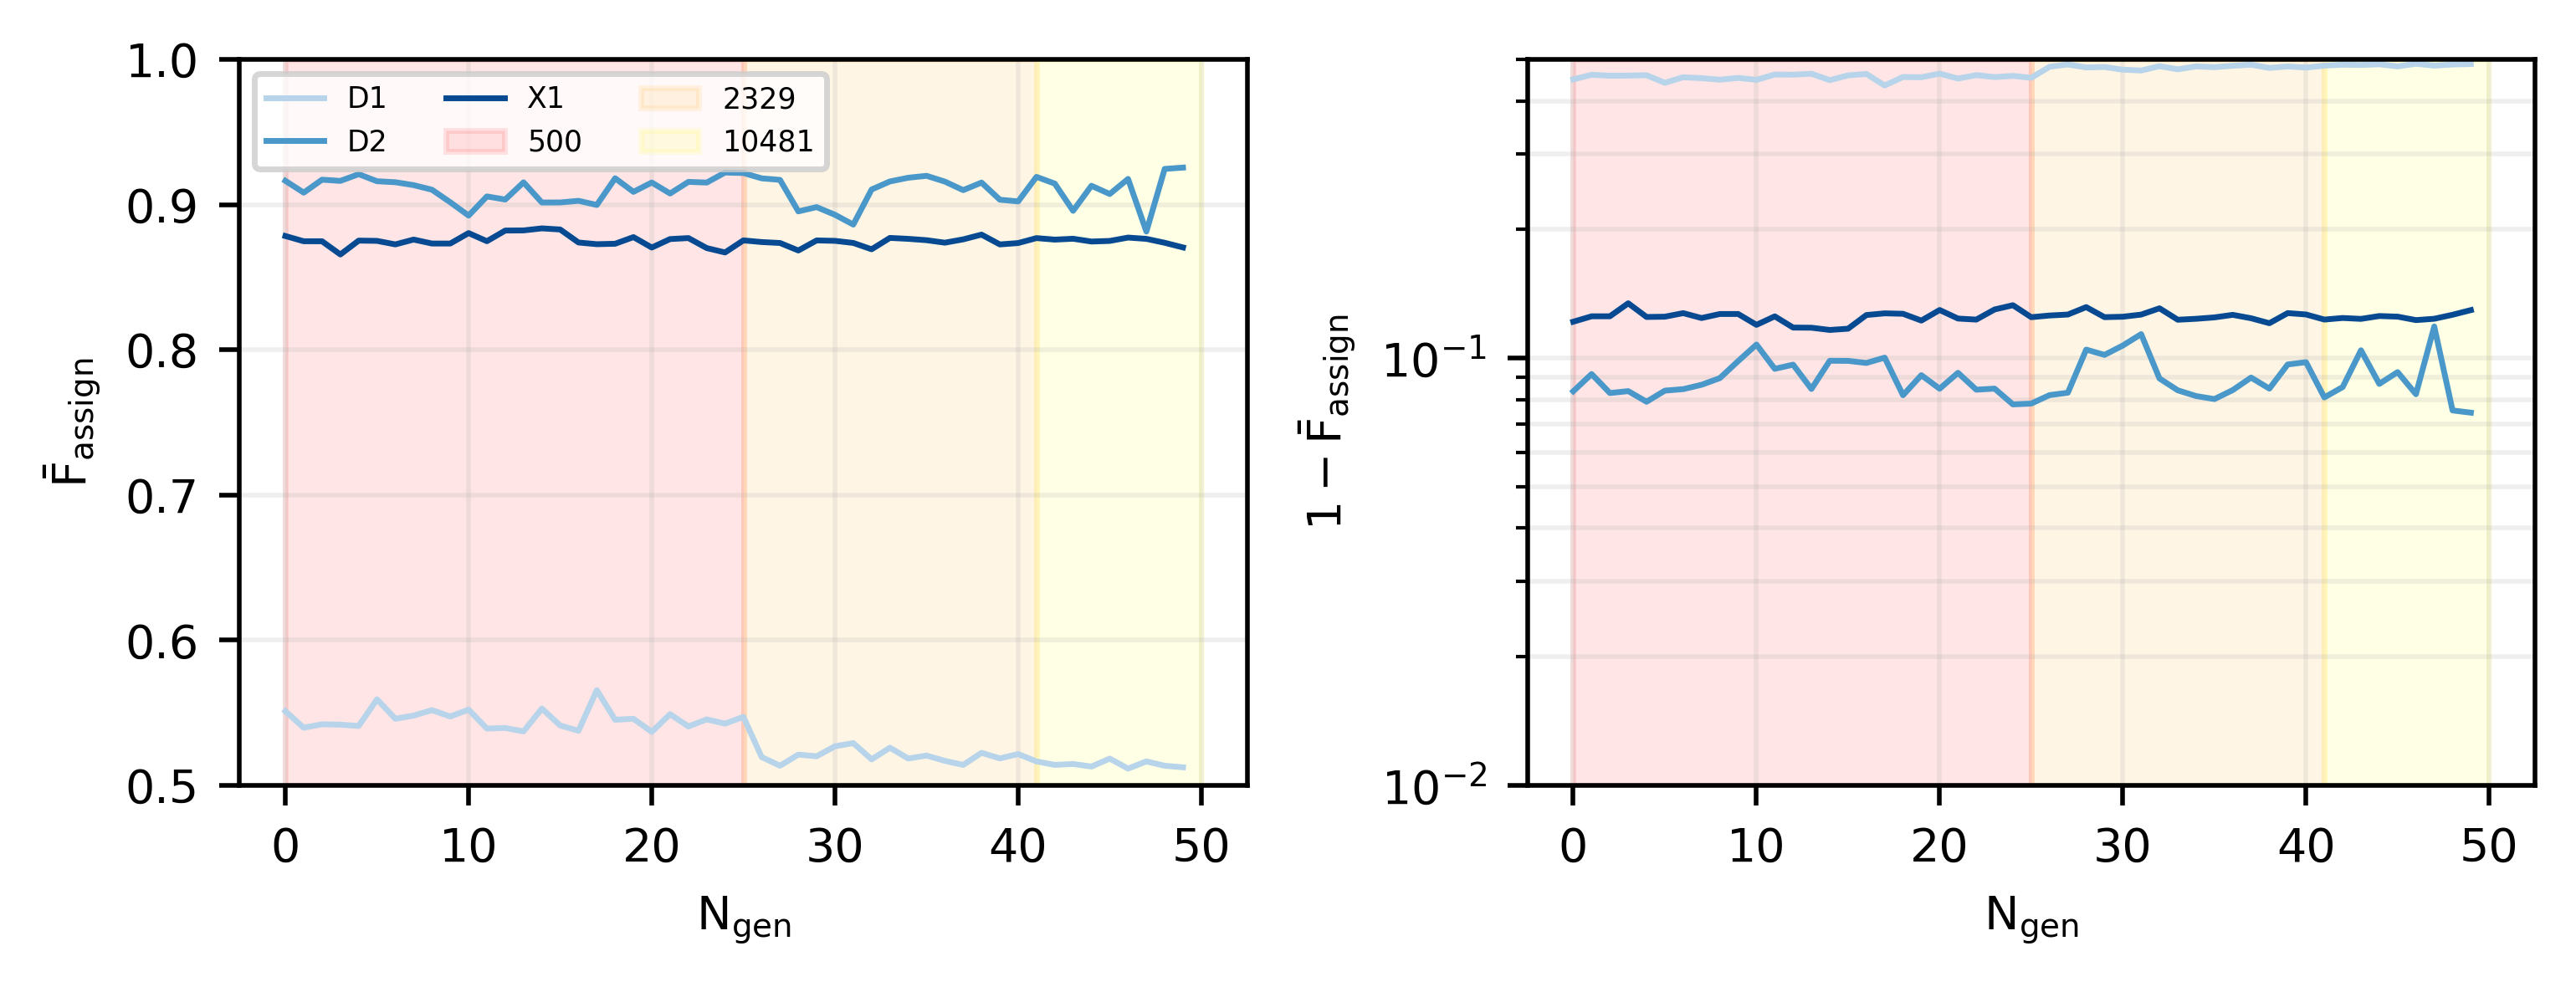

In [35]:
qubits = dataset.elements

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)

# Choose a colormap and generate spaced colors
cmap = mpl.colormaps['Blues']
n = len(qubits)
spacing = np.linspace(0.3, 0.9, n)  # Avoid extremes (too light or too dark)
colors = [cmap(s) for s in spacing]

for idx, qubit in enumerate(qubits):
    color = colors[idx]
    ax1.plot(range(Ngen), data[qubit]['mean']['assignfid_av'], lw=1, label=qubit, color=color)
    ax2.plot(range(Ngen), 1 - data[qubit]['mean']['assignfid_av'], lw=1,label=qubit, color=color)

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.set_ylabel(r'$\bar{\mathrm{F}}_\mathrm{assign}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \bar{\mathrm{F}}_\mathrm{assign}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

#plot where we change repetitions:
ax1.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax1.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax1.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax2.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax2.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax2.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax1.legend(ncols=3, fontsize=5)

plt.tight_layout()
plt.show()

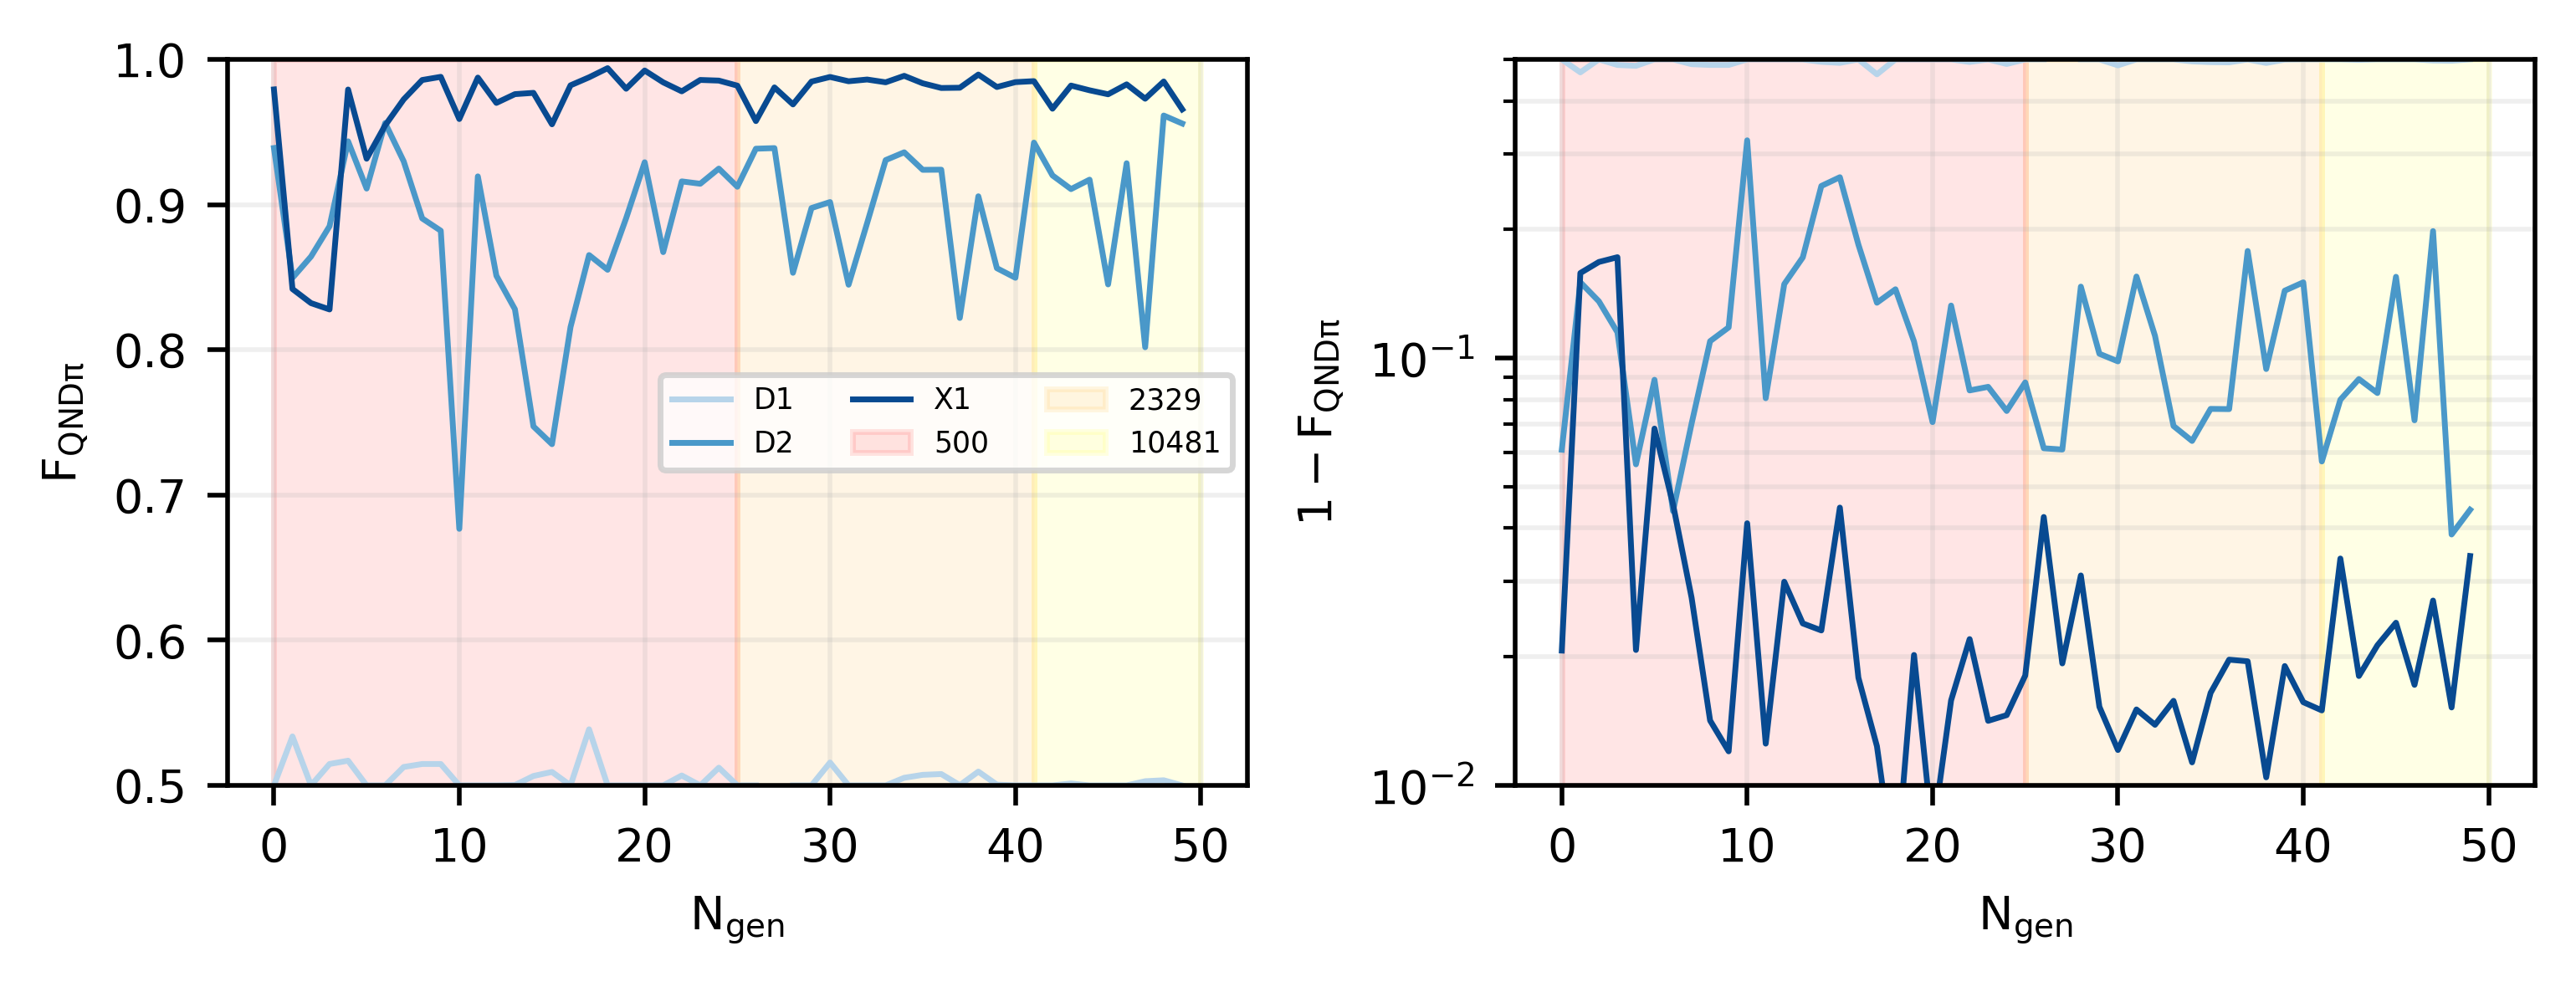

In [36]:
qubits = dataset.elements

fig, axes = plt.subplots(ncols=2, nrows=1)
ax1 = axes[0]
ax2 = axes[1]

fig.set_size_inches(6.2, 2.4)

# Choose a colormap and generate spaced colors
cmap = mpl.colormaps['Blues']
n = len(qubits)
spacing = np.linspace(0.3, 0.9, n)  # Avoid extremes (too light or too dark)
colors = [cmap(s) for s in spacing]

for idx, qubit in enumerate(qubits):
    color = colors[idx]
    ax1.plot(range(Ngen), data[qubit]['mean']['qndpifid'], lw=1, label=qubit, color=color)
    ax2.plot(range(Ngen), 1 - data[qubit]['mean']['qndpifid'], lw=1,label=qubit, color=color)

# Axis formatting
ax1.grid(which='both', alpha=.2)
ax1.set_ylabel(r'$\mathrm{F}_\mathrm{QND \pi}$')
ax1.set_xlabel(r'N$_\mathrm{gen}$')
ax1.set_ylim(0.5, 1)

ax2.grid(which='both', alpha=.2)
ax2.set_ylabel(r'$1 - \mathrm{F}_\mathrm{QND \pi}$')
ax2.set_xlabel(r'N$_\mathrm{gen}$')
ax2.set_yscale('log')
ax2.set_ylim(1e-2, 0.5)

#plot where we change repetitions:
ax1.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax1.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax1.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax2.axvspan(0, red_end, color='red', alpha=0.1, label='500')
ax2.axvspan(red_end, orange_end, color='orange', alpha=0.1, label='2329')
ax2.axvspan(orange_end, yellow_end, color='yellow', alpha=0.1, label='10481')

ax1.legend(ncols=3, fontsize=5)

plt.tight_layout()
plt.show()

In [37]:
tuid = '20250630-144102-084-a91d96'
dataset_ws_D1_group = load_dataset(tuid)

tuid = '20250630-123131-395-460aba'
dataset_ws_D1_solo = load_dataset(tuid)

In [38]:
dataset_ws_D1_group

<xarray.Dataset> Size: 22kB
Dimensions:  (dim_0: 100)
Coordinates:
    x0       (dim_0) float64 800B 6.967e+09 6.958e+09 ... 6.931e+09 6.928e+09
    x1       (dim_0) float64 800B 0.0641 0.03692 0.08575 ... 0.008251 0.03786
    x2       (dim_0) float64 800B 4.32e-07 4.52e-07 ... 3.76e-07 3.48e-07
    x3       (dim_0) float64 800B 7.221e+09 7.203e+09 ... 7.19e+09 7.202e+09
    x4       (dim_0) float64 800B 0.1193 0.1186 0.0706 ... 0.05156 0.0243
    x5       (dim_0) float64 800B 4.08e-07 3.2e-07 ... 1.08e-07 1.72e-07
    x6       (dim_0) float64 800B 7.623e+09 7.648e+09 ... 7.611e+09 7.636e+09
    x7       (dim_0) float64 800B 0.0999 0.01592 0.08625 ... 0.1147 0.0294
    x8       (dim_0) float64 800B 3.56e-07 3.2e-07 3.68e-07 ... 8.4e-08 2.88e-07
Dimensions without coordinates: dim_0
Data variables: (12/19)
    y0       (dim_0) float64 800B -6.02 -5.658 -7.892 ... -5.352 -6.433 -4.55
    y1       (dim_0) float64 800B 0.5708 0.5401 0.5625 ... 0.5377 0.5334 0.538
    y2       (dim_0) float64 800B 0.5508 0.5385 0.5778 ... 0.527 0.5283 0.5244
    y3       (dim_0) float64 800B 0.5763 0.5496 0.5672 ... 0.5433 0.5286 0.5503
    y4       (dim_0) float64 800B 0.5854 0.5322 0.5425 ... 0.5428 0.5433 0.5394
    y5       (dim_0) float64 800B 0.5 0.5141 0.5119 0.5 ... 0.5198 0.5 0.5 nan
    ...       ...
    y13      (dim_0) float64 800B 0.5714 0.8365 0.791 ... 0.7626 0.5481 0.6045
    y14      (dim_0) float64 800B 0.5871 0.9458 0.8819 ... 0.8297 0.538 0.5455
    y15      (dim_0) float64 800B 0.5899 0.9166 0.9043 ... 0.815 0.5666 0.6356
    y16      (dim_0) float64 800B 0.5371 0.647 0.5869 ... 0.6432 0.5398 0.6325
    y17      (dim_0) float64 800B 0.5909 0.8603 0.7846 ... 0.8154 0.5 0.6765
    y18      (dim_0) float64 800B 0.5 0.5995 0.743 0.7252 ... 0.5 0.6216 0.5 0.5
Attributes:
    tuid:                             20250630-144102-084-a91d96
    name:                             CMAES_Warm_Start ['D1', 'D2', 'X1']
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [39]:
dataset_ws_D1_solo

<xarray.Dataset> Size: 2kB
Dimensions:  (dim_0: 20)
Coordinates:
    x0       (dim_0) float64 160B 6.977e+09 7.001e+09 ... 7.004e+09 6.974e+09
    x1       (dim_0) float64 160B 0.06611 0.03316 0.09878 ... 0.05413 0.01694
    x2       (dim_0) float64 160B 4.52e-07 3.68e-07 ... 2.68e-07 1.32e-07
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 160B -2.603 -7.261 -1.622 ... -2.817 -4.154 -1.549
    y1       (dim_0) float64 160B 0.8152 0.9707 0.5925 ... 0.8559 0.9128 0.5749
    y2       (dim_0) float64 160B 0.7674 0.997 0.5917 ... 0.952 0.9115 0.5288
    y3       (dim_0) float64 160B 0.8433 0.998 0.6259 ... 0.9647 0.924 0.6188
    y4       (dim_0) float64 160B 0.8348 0.9173 0.5599 ... 0.651 0.9029 0.577
    y5       (dim_0) float64 160B 0.6321 0.9841 0.5162 ... 0.9141 0.8871 0.5254
    y6       (dim_0) float64 160B 0.5994 0.976 0.5152 0.7958 ... 0.5849 0.82 0.5
Attributes:
    tuid:                             20250630-123131-395-460aba
    name:                             CMAES_Warm_Start ['D1']
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

In [40]:
D1_freq_group = dataset_ws_D1_group['x0'].values
D1_ampl_group = dataset_ws_D1_group['x1'].values
D1_dur_group = dataset_ws_D1_group['x2'].values

D1_freq_solo = dataset_ws_D1_solo['x0'].values
D1_ampl_solo = dataset_ws_D1_solo['x1'].values
D1_dur_solo = dataset_ws_D1_solo['x2'].values

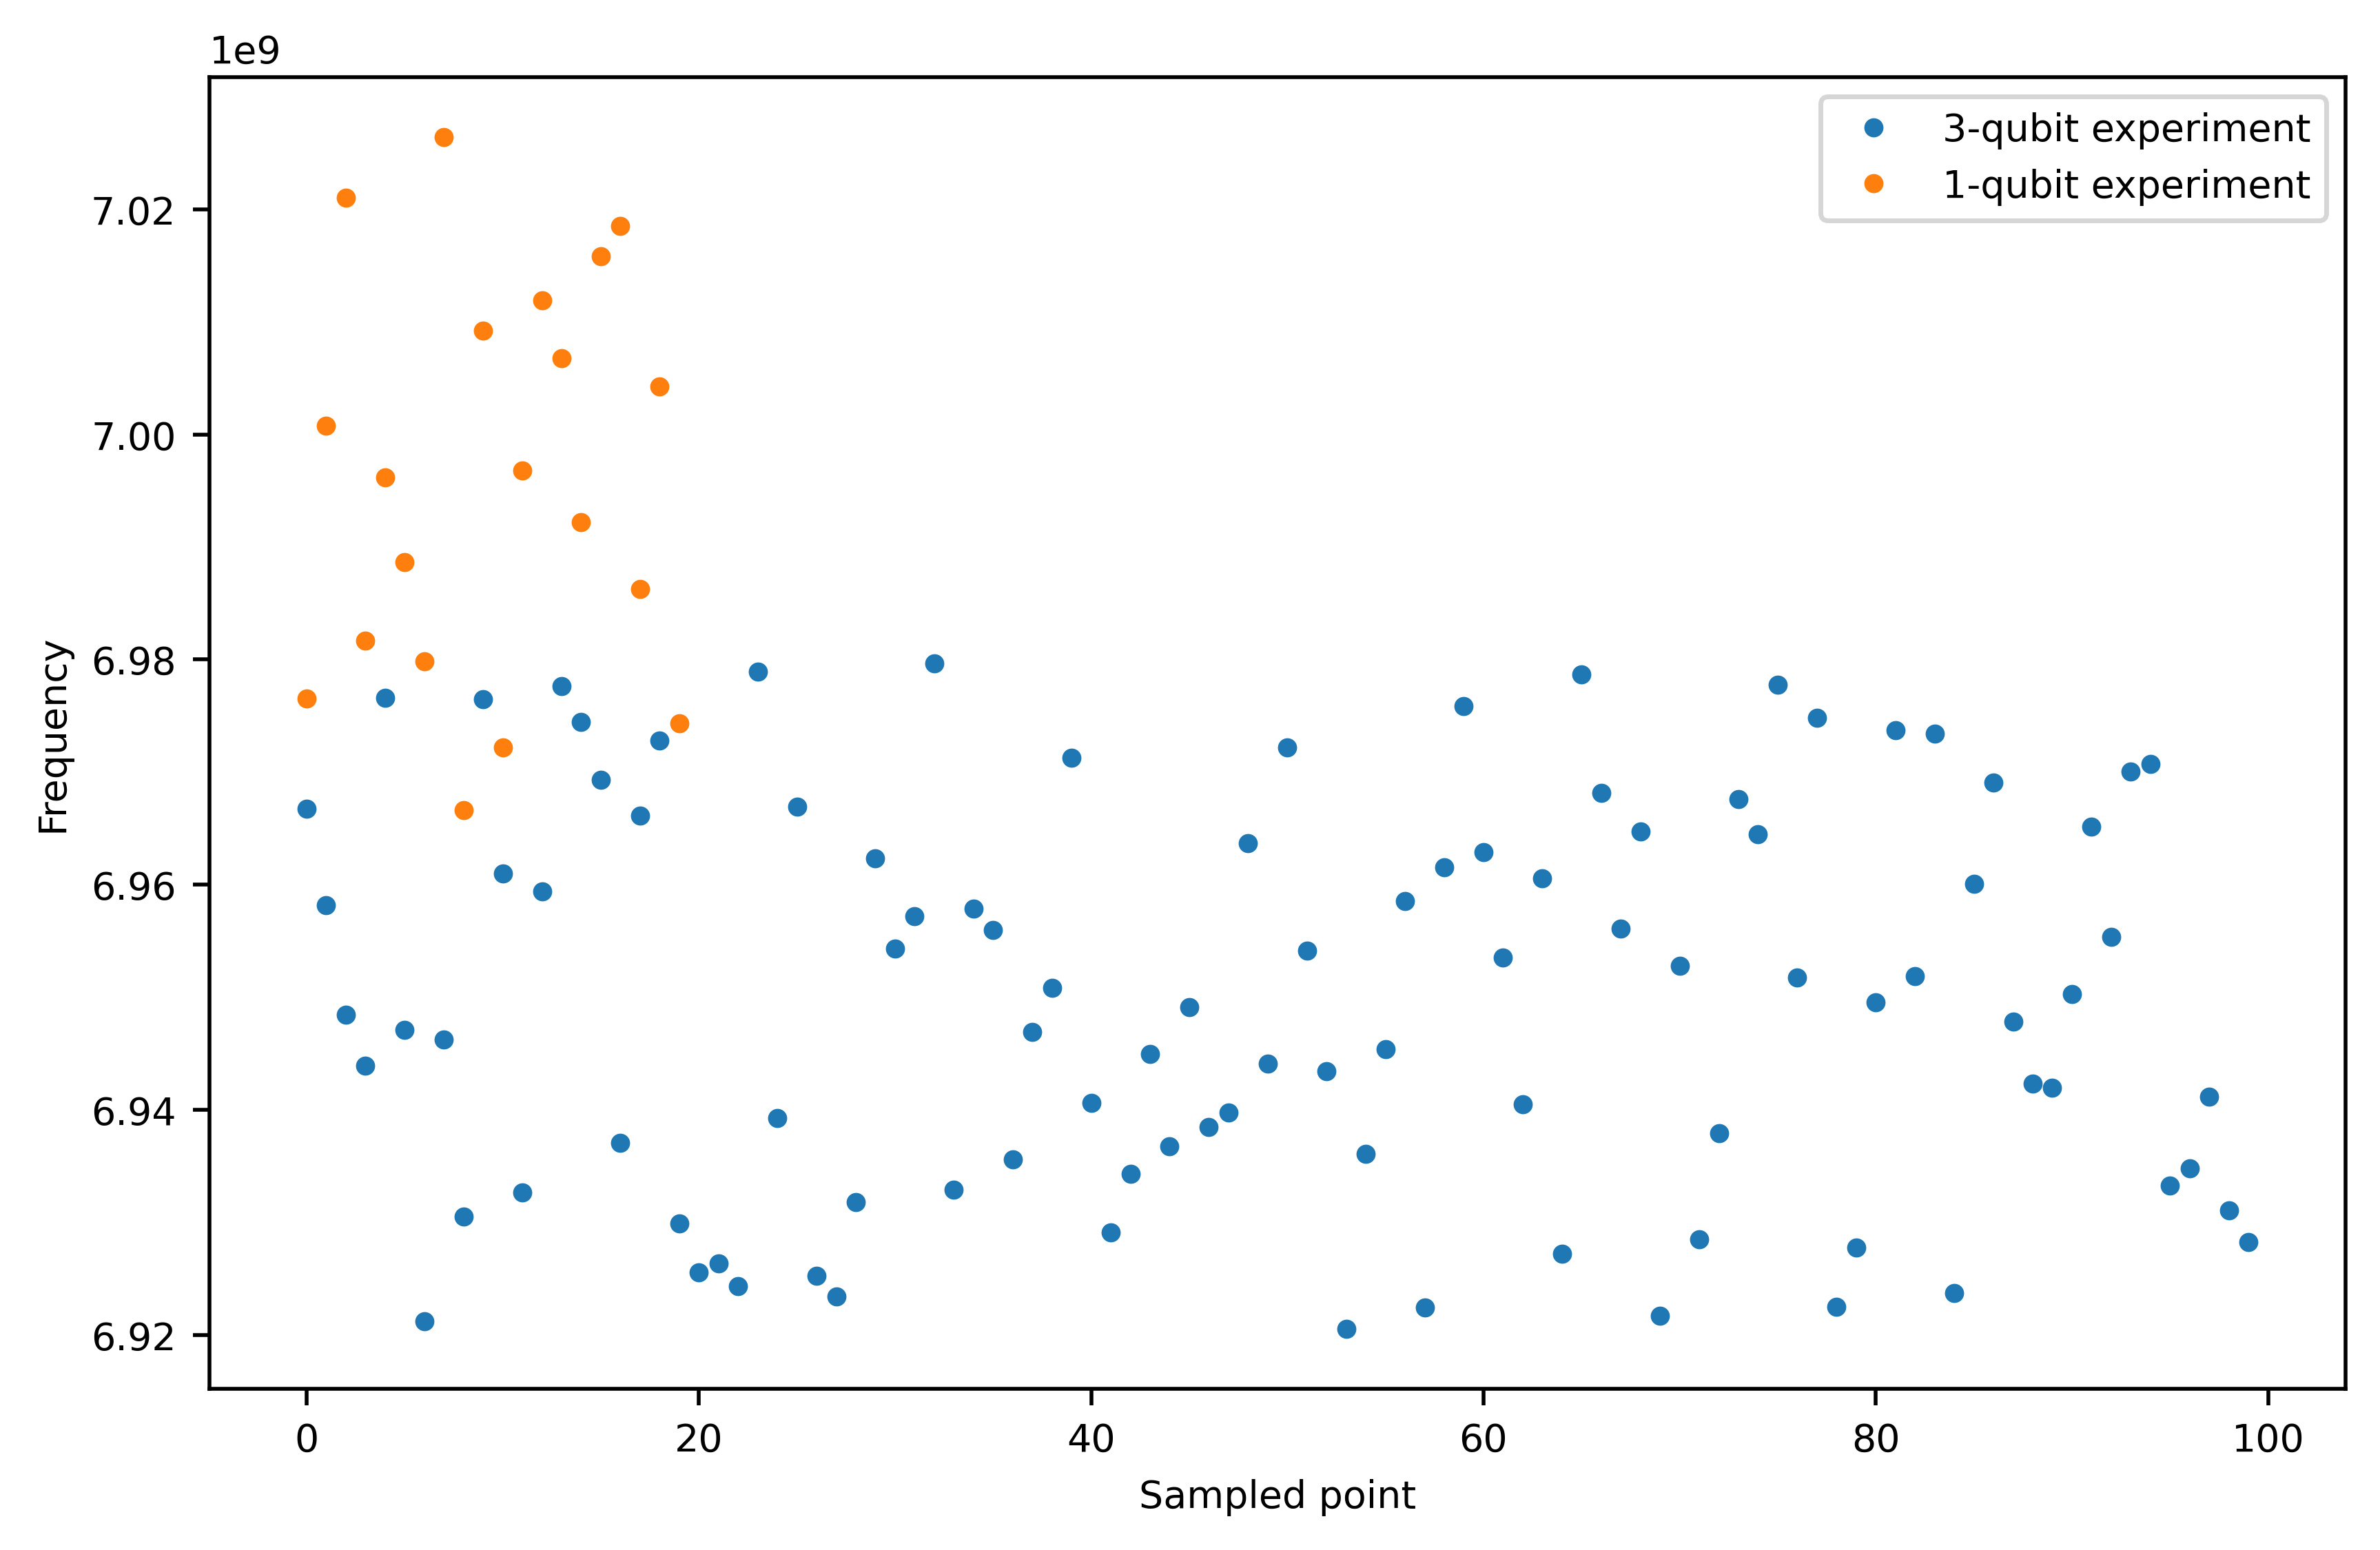

In [46]:
plt.plot(D1_freq_group, ".", label="3-qubit experiment")
plt.plot(D1_freq_solo, ".", label = "1-qubit experiment")
plt.xlabel("Sampled point")
plt.ylabel("Frequency")
plt.legend()
plt.show()

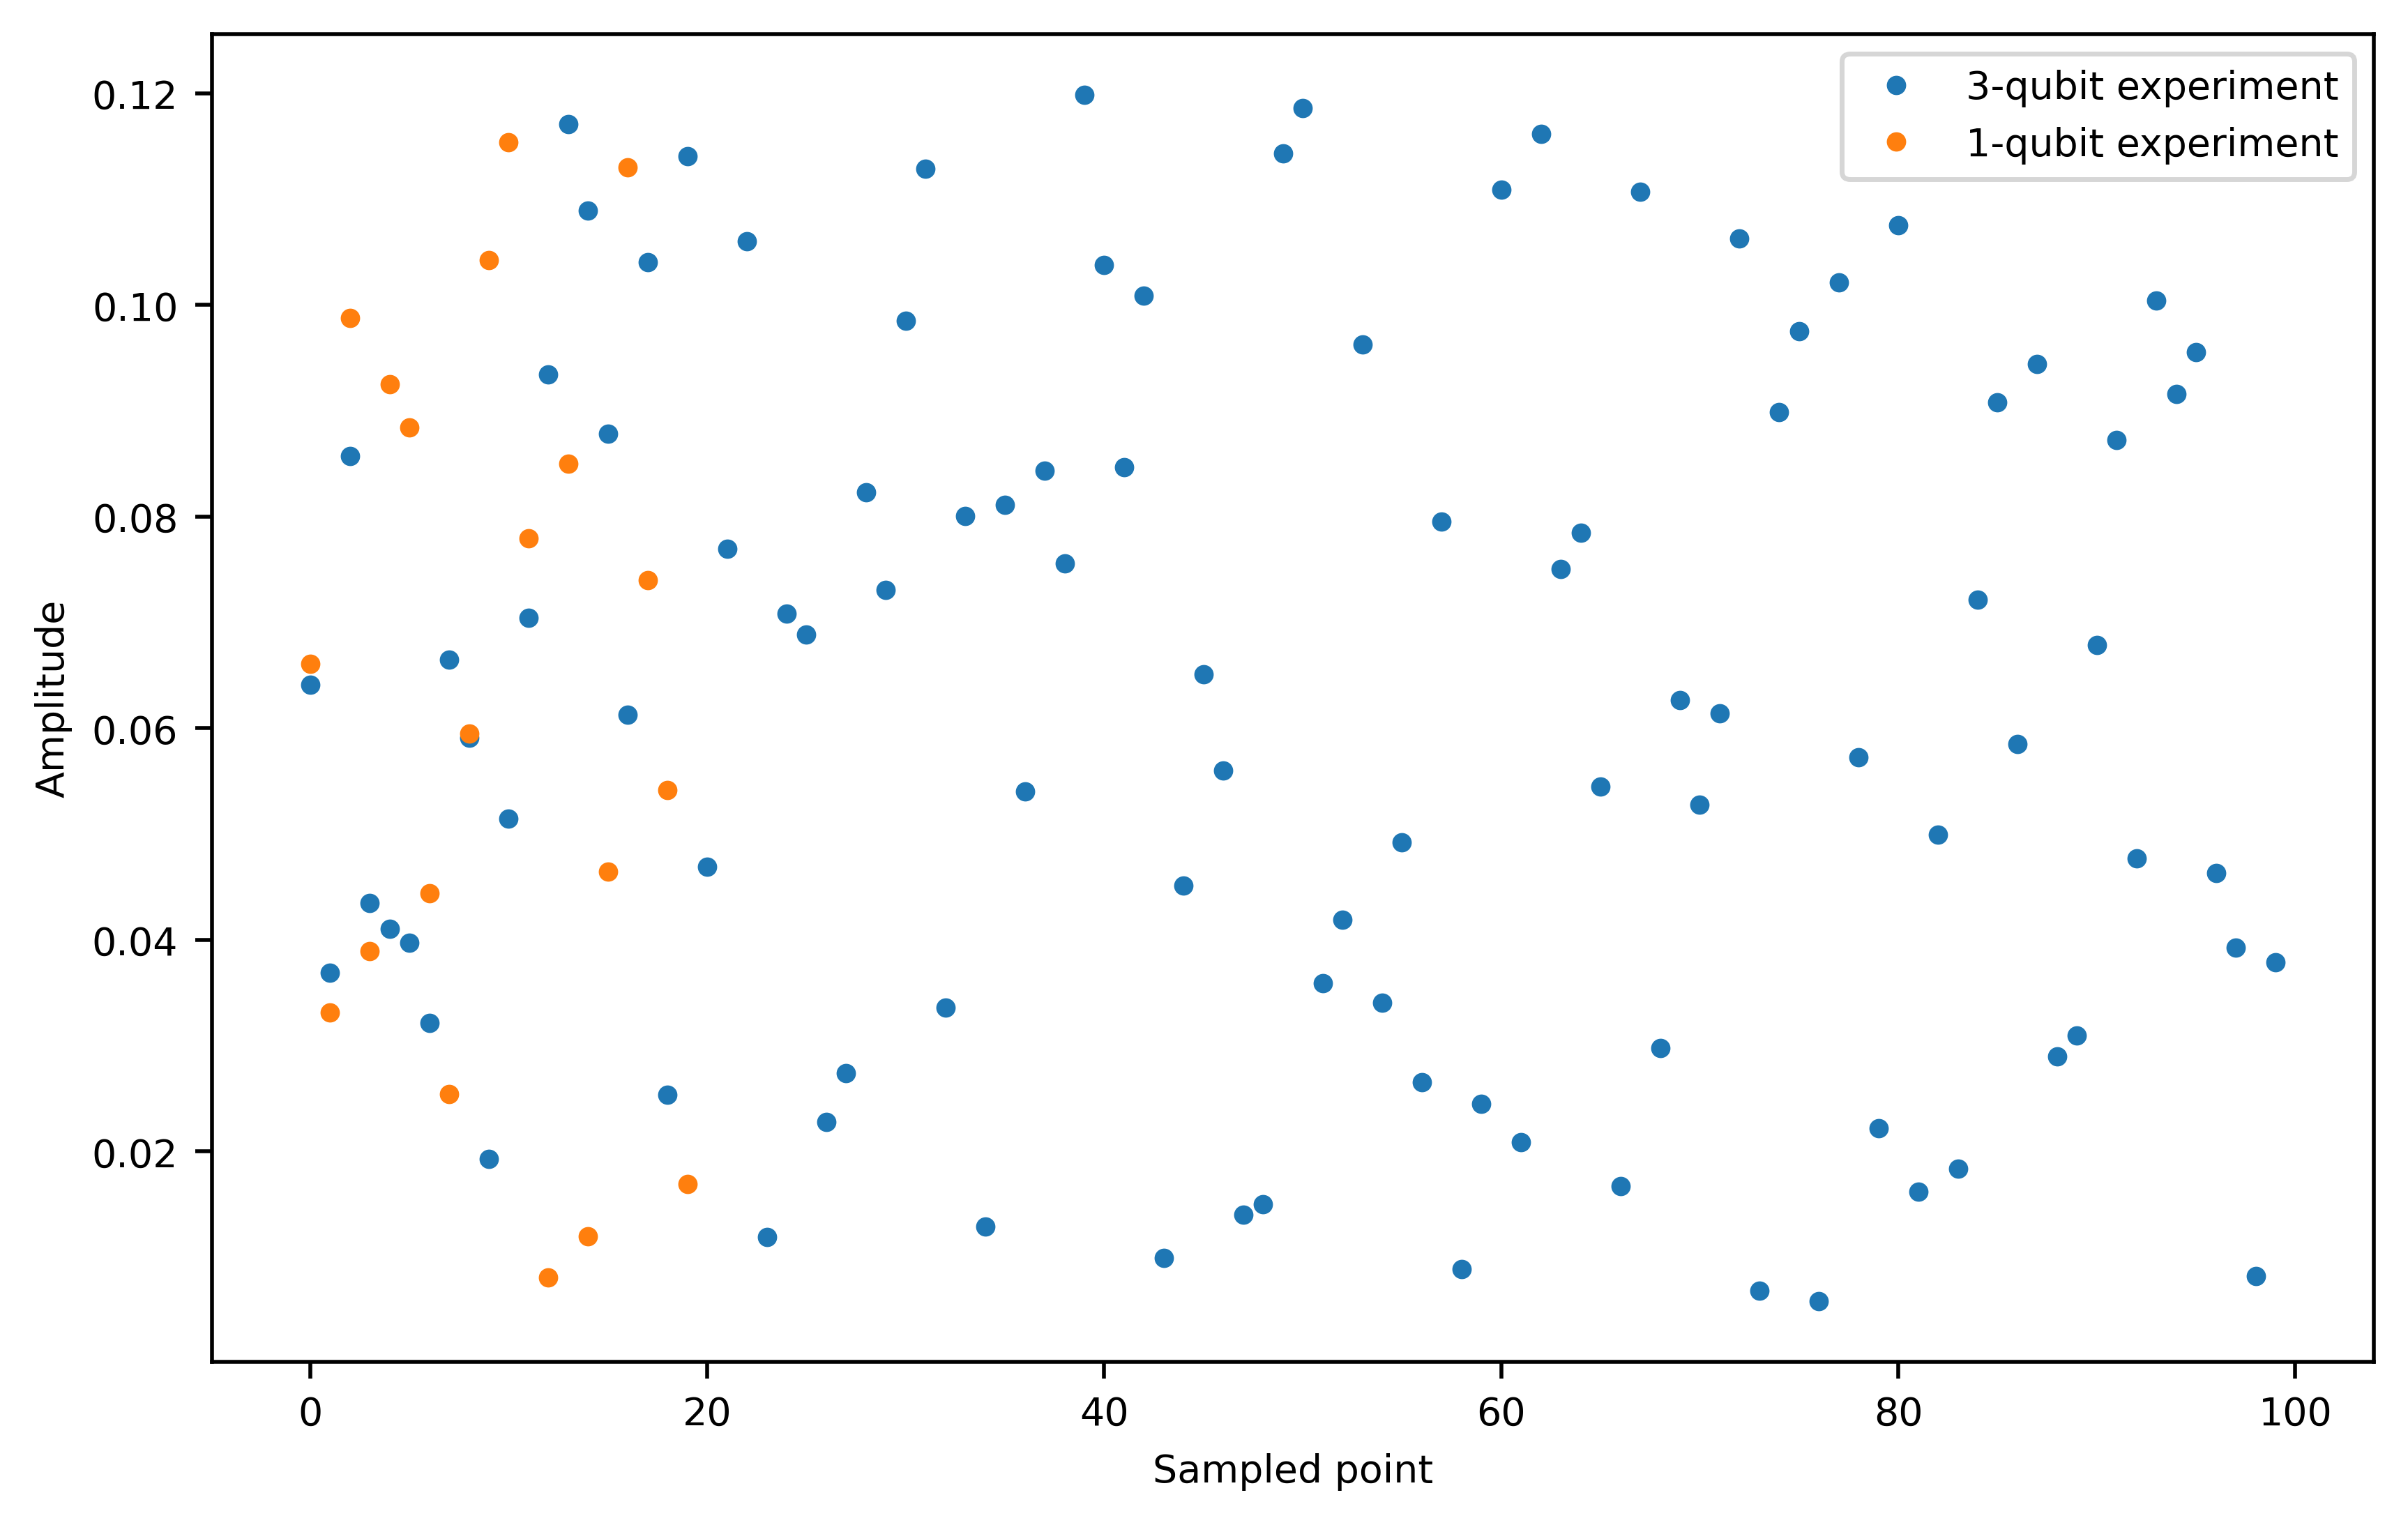

In [47]:
plt.plot(D1_ampl_group, ".", label="3-qubit experiment")
plt.plot(D1_ampl_solo, ".", label = "1-qubit experiment")
plt.xlabel("Sampled point")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

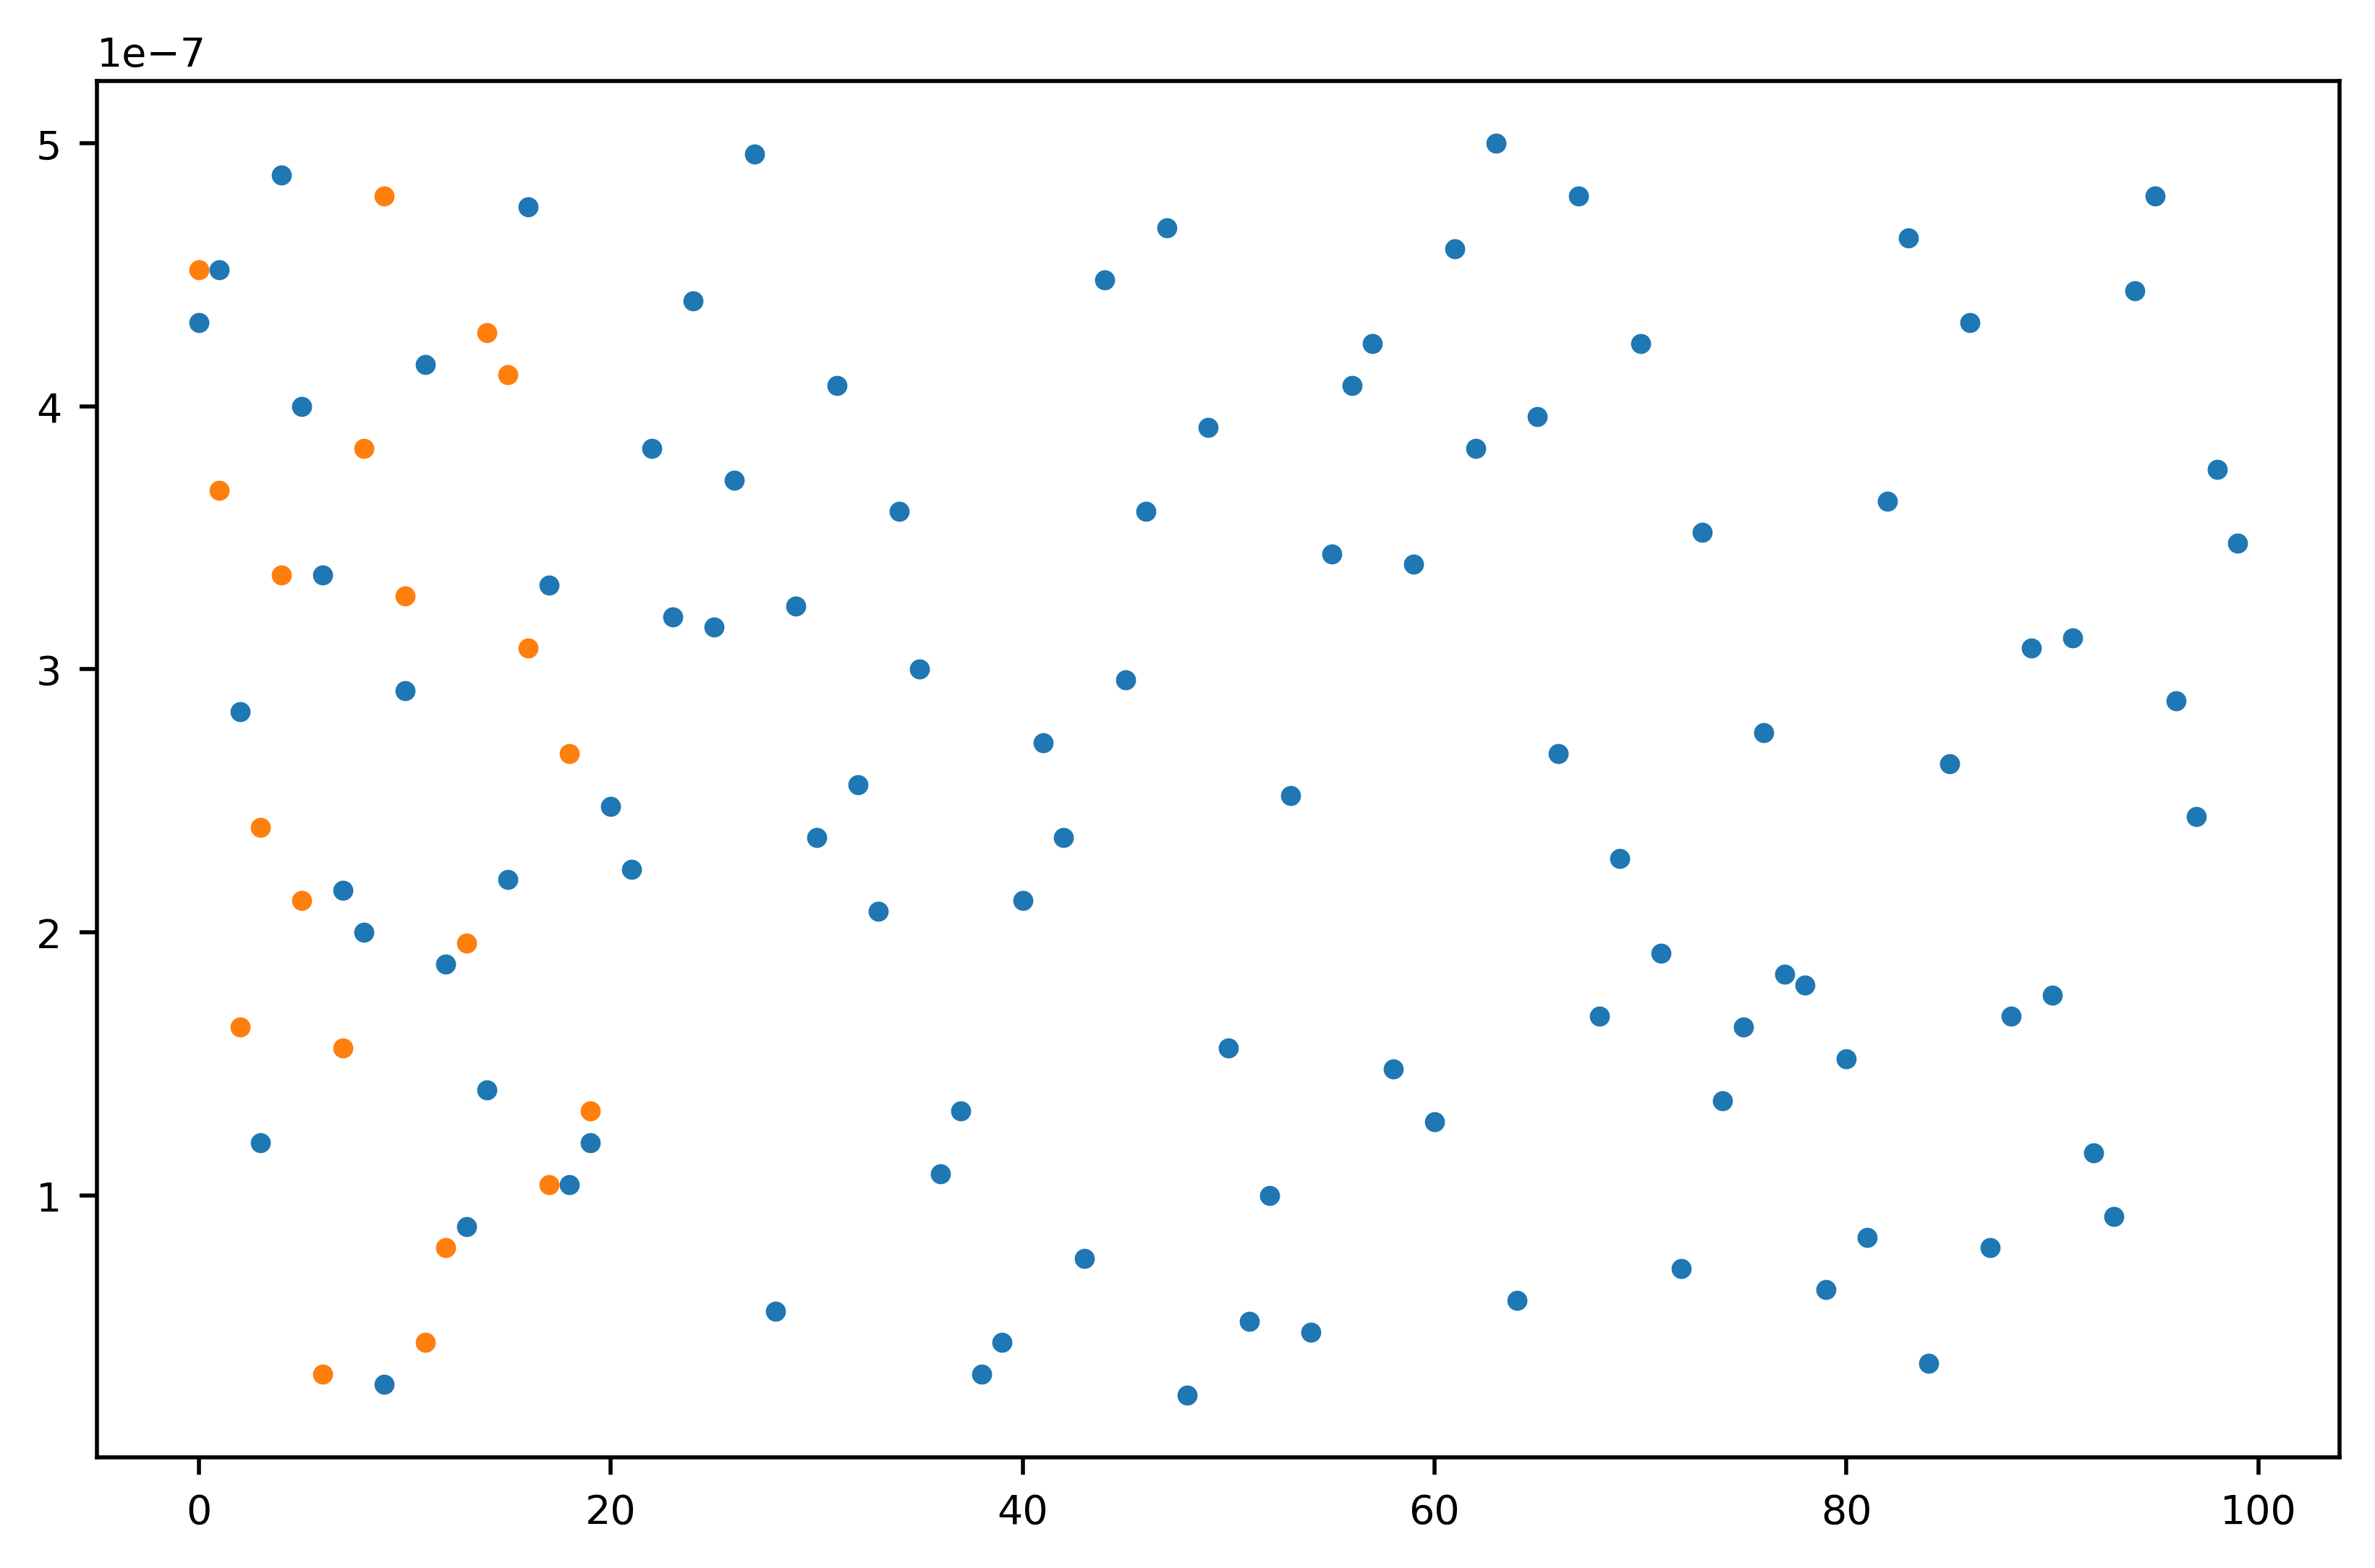

In [43]:
plt.plot(D1_dur_group, ".")
plt.plot(D1_dur_solo, ".")
plt.show()